# ENV CHECK (embeddings + multiprocessing)

# figure settings
import scanpy as sc
import anndata as ad
import os
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=600,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/processed_datasets/share_seq_brain"
#%ls $DATADIR
files = [os.path.join(DATADIR, 'old_anndata_brain_share_seq_geneactivity_rna_merged.h5ad')]

int_files = ['liger_jnmf_integration.h5ad', 
             'scJoint_integration.h5ad', 
             'seurat_cca_integration.h5ad', 
             'seurat_rpca_integration.h5ad']

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/integrated_outputs/share_seq_brain_shared_genes_full"
#%ls $DATADIR
for i in int_files:
    files.append(os.path.join(DATADIR, i))
    
data = ad.read(files[0])
sc.pp.pca(data)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.pl.umap(data, color='broad_annotations')

from multiprocessing import Process, Queue
from time import sleep


def my_func(n, l):
    if n % 2 == 0:
        sleep(5)
    for i in l:
        print(f'Process {n}: {i}\n')
    
processes = []
my_list = range(1, 5)
for i in range(8):
    p = Process(target=my_func, args=(i, my_list))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()

# METRICS ANALYSIS

In [1]:
# Load packages 
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import matplotlib.pyplot as plt
import scmoib
import numpy as np
import tqdm

In [2]:
# figure settings
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

# PREPARE DATA PATHS

In [3]:
DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/processed_datasets/share_seq_brain"
files = [os.path.join(DATADIR, 'old_anndata_brain_share_seq_geneactivity_rna_merged.h5ad')]

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/integrated_outputs/share_seq_brain_shared_genes_full"
int_files = ['liger_jnmf_integration.h5ad', 
             'scJoint_integration.h5ad', 
             'seurat_cca_integration.h5ad', 
             'seurat_rpca_integration.h5ad', 
             'scalex.h5ad', 
             'scot.h5ad']

for i in int_files:
    files.append(os.path.join(DATADIR, i))

# PARAMETERS FOR SCRIPT

In [4]:
# ID for each dataset
ids = ['unintegrated', 'liger', 'scjoint', 'seurat_cca', 'seurat_rpca', 'scalex', 'scot']
# Modes for check_anndata function
modes = ['raw', 'comps', 'comps', 'count', 'count', 'graph', 'comps']
# Column name with cell type annotations
cell_type_col = 'broad_annotations'
# Embedding names for "comps mode" (just enter None for other methods)
reps = [None, 'X_inmf_embedding', 'X_scjoint_embedding', None, None, None, 'scot_embedding']
# Checking that everything is ok
assert len(ids) == len(modes) == len(reps)

# AUTOMATED PART

In [5]:
%%time
my_obj = scmoib.tl.MetricsCalculator()
adata_list = []

for i in tqdm.tqdm(files):
    adata = ad.read(i)
    adata_id = ids[files.index(i)]
    clust_id = 'louvain'
    ct_id = cell_type_col
    bc_list = list(adata.obs.index)
    # extract RNA barcodes
    bc_list1 = bc_list[:len(bc_list) // 2]
    # extract ATAC barcodes
    bc_list2 = bc_list[len(bc_list) // 2:]
    mode = modes[files.index(i)]
    rep = reps[files.index(i)]
    scmoib.pp.check_anndata(adata, ct_id, mode=mode, use_rep=rep)
    print('-' * 10)
    try:
        my_obj.node_metrics(adata, adata_id, bc_list1, bc_list2, ct_id, n_jobs=8)
        my_obj.spec_dist(adata, adata_id=adata_id, n_metr=10)
    except:
        print("no graph for spec dist")
    try:
        my_obj._accuracy_paired_omics(adata, adata_id, bc_list1, bc_list2, 'omic_batch', clust_id)
        my_obj._accuracy_paired_omics_per_cell_type(adata, bc_list1, bc_list2, 
                                                    'omic_batch', clust_id, ct_id)
        my_obj.ami(adata, adata_id, ct_id, clust_id)
        my_obj.ari(adata, adata_id, ct_id, clust_id)
        my_obj.nmi(adata, adata_id, ct_id, clust_id)
        my_obj.homogeneity(adata, adata_id, ct_id, clust_id)
    
    except ValueError as err:
        print(f"Trouble with {adata_id}")
        print(err.args[0])

    my_obj._graph_connectivity(adata, adata_id, ct_id)
    my_obj._average_dist_between_matching_barcodes(adata, adata_id, bc_list1, bc_list2, metric='cosine')
    my_obj.silhouette(adata, adata_id, cell_label=ct_id, embed='X_umap')
    my_obj.silhouette_batch(adata, adata_id, batch_key='omic_batch', cell_label=ct_id, embed='X_umap')
    my_obj.isolated_labels(adata, adata_id, 'omic_batch', ct_id, embed='X_umap')
    adata_list.append(adata)
my_obj.get_df()

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Running pre-flight check


Clustering...
step 0
got 23 at resolution 1.5
step 1
got 17 at resolution 0.75
step 2
got 12 at resolution 0.375
step 3
got 8 at resolution 0.1875
step 4
got 3 at resolution 0.09375
step 5
got 5 at resolution 0.140625
step 6
got 6 at resolution 0.1640625
step 7
got 7 at resolution 0.17578125
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
 14%|██████▍                                      | 1/7 [01:38<09:49, 98.24s/it]

Running pre-flight check
Clustering...
step 0
got 20 at resolution 1.5
step 1
got 13 at resolution 0.75
step 2
got 9 at resolution 0.375
step 3
got 7 at resolution 0.1875
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
 29%|████████████▊                                | 2/7 [02:36<06:14, 74.97s/it]

Running pre-flight check
Clustering...
step 0
got 15 at resolution 1.5
step 1
got 10 at resolution 0.75
step 2
got 6 at resolution 0.375
step 3
got 10 at resolution 0.5625
step 4
got 9 at resolution 0.46875
step 5
got 8 at resolution 0.421875
step 6
got 7 at resolution 0.3984375
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
 43%|███████████████████▎                         | 3/7 [03:37<04:34, 68.58s/it]

Running pre-flight check


Clustering...
step 0
got 29 at resolution 1.5
step 1
got 20 at resolution 0.75
step 2
got 13 at resolution 0.375
step 3
got 11 at resolution 0.1875
step 4
got 9 at resolution 0.09375
step 5
got 7 at resolution 0.046875
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
 57%|█████████████████████████▋                   | 4/7 [04:40<03:18, 66.19s/it]

Running pre-flight check


Clustering...
step 0
got 31 at resolution 1.5
step 1
got 18 at resolution 0.75
step 2
got 15 at resolution 0.375
step 3
got 10 at resolution 0.1875
step 4
got 6 at resolution 0.09375
step 5
got 8 at resolution 0.140625
step 6
got 9 at resolution 0.1171875
step 7
got 7 at resolution 0.10546875
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
 71%|████████████████████████████████▏            | 5/7 [05:42<02:09, 64.86s/it]

Running pre-flight check
Clustering...
step 0
got 15 at resolution 1.5
step 1
got 11 at resolution 0.75
step 2
got 6 at resolution 0.375
step 3
got 8 at resolution 0.5625
step 4
got 8 at resolution 0.46875
step 5
got 7 at resolution 0.421875
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
 86%|██████████████████████████████████████▌      | 6/7 [06:51<01:06, 66.13s/it]

Running pre-flight check
Clustering...
step 0
got 19 at resolution 1.5
step 1
got 13 at resolution 0.75
step 2
got 6 at resolution 0.375
step 3
got 9 at resolution 0.5625
step 4
got 6 at resolution 0.46875
step 5
got 8 at resolution 0.515625
step 6
got 7 at resolution 0.4921875
----------


Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k
100%|█████████████████████████████████████████████| 7/7 [07:52<00:00, 67.43s/it]

CPU times: user 32min 6s, sys: 16min 11s, total: 48min 18s
Wall time: 7min 52s


conn_ratio  spec_dist_10  accuracy       AMI       ARI  \
unintegrated         1.0      0.147571  0.000632  0.254587  0.121660   
liger                1.0      0.854919  0.583755  0.283732  0.299474   
scjoint              1.0      0.793738  0.461757  0.588411  0.521878   
seurat_cca           1.0      0.849134  0.849874  0.084305  0.003070   
seurat_rpca          1.0      0.795325  0.765171  0.094684 -0.026638   
scalex               1.0      0.975452  0.523704  0.275548  0.254211   
scot                 1.0      0.881389  0.449747  0.362181  0.268040   

                   NMI  homogeneity  graph connectivity broad_annotations  \
unintegrated  0.256195     0.260348                              0.682698   
liger         0.285193     0.304363                              0.847966   
scjoint       0.589200     0.660827                              0.912184   
seurat_cca    0.087487     0.057767                              0.895067   
seurat_rpca   0.097519     0.070147                              0.869876   
scalex        0.277148     0.277078                              0.948749   
scot          0.363346     0.427184                              0.860145   

              pairwise_distance  sil_global  sil_clus  il_sil  il_clus  
unintegrated           0.834608    0.433757  0.263867     NaN      NaN  
liger                  0.834608    0.505152  0.719293     NaN      NaN  
scjoint                0.834608    0.717810  0.494640     NaN      NaN  
seurat_cca             0.976174    0.390706  0.694866     NaN      NaN  
seurat_rpca            0.983140    0.419544  0.556388     NaN      NaN  
scalex                 0.869520    0.520941  0.660322     NaN      NaN  
scot                   0.834608    0.539439  0.851059     NaN      NaN

# EXTRACT METRICS DATAFRAME FROM CALCULATOR

In [6]:
df = my_obj.get_df()
df

conn_ratio  spec_dist_10  accuracy       AMI       ARI  \
unintegrated         1.0      0.147571  0.000632  0.254587  0.121660   
liger                1.0      0.854919  0.583755  0.283732  0.299474   
scjoint              1.0      0.793738  0.461757  0.588411  0.521878   
seurat_cca           1.0      0.849134  0.849874  0.084305  0.003070   
seurat_rpca          1.0      0.795325  0.765171  0.094684 -0.026638   
scalex               1.0      0.975452  0.523704  0.275548  0.254211   
scot                 1.0      0.881389  0.449747  0.362181  0.268040   

                   NMI  homogeneity  graph connectivity broad_annotations  \
unintegrated  0.256195     0.260348                              0.682698   
liger         0.285193     0.304363                              0.847966   
scjoint       0.589200     0.660827                              0.912184   
seurat_cca    0.087487     0.057767                              0.895067   
seurat_rpca   0.097519     0.070147                              0.869876   
scalex        0.277148     0.277078                              0.948749   
scot          0.363346     0.427184                              0.860145   

              pairwise_distance  sil_global  sil_clus  il_sil  il_clus  
unintegrated           0.834608    0.433757  0.263867     NaN      NaN  
liger                  0.834608    0.505152  0.719293     NaN      NaN  
scjoint                0.834608    0.717810  0.494640     NaN      NaN  
seurat_cca             0.976174    0.390706  0.694866     NaN      NaN  
seurat_rpca            0.983140    0.419544  0.556388     NaN      NaN  
scalex                 0.869520    0.520941  0.660322     NaN      NaN  
scot                   0.834608    0.539439  0.851059     NaN      NaN

In [7]:
df.drop(columns=['conn_ratio', 'il_sil', 'il_clus'], inplace=True)
df

spec_dist_10  accuracy       AMI       ARI       NMI  \
unintegrated      0.147571  0.000632  0.254587  0.121660  0.256195   
liger             0.854919  0.583755  0.283732  0.299474  0.285193   
scjoint           0.793738  0.461757  0.588411  0.521878  0.589200   
seurat_cca        0.849134  0.849874  0.084305  0.003070  0.087487   
seurat_rpca       0.795325  0.765171  0.094684 -0.026638  0.097519   
scalex            0.975452  0.523704  0.275548  0.254211  0.277148   
scot              0.881389  0.449747  0.362181  0.268040  0.363346   

              homogeneity  graph connectivity broad_annotations  \
unintegrated     0.260348                              0.682698   
liger            0.304363                              0.847966   
scjoint          0.660827                              0.912184   
seurat_cca       0.057767                              0.895067   
seurat_rpca      0.070147                              0.869876   
scalex           0.277078                              0.948749   
scot             0.427184                              0.860145   

              pairwise_distance  sil_global  sil_clus  
unintegrated           0.834608    0.433757  0.263867  
liger                  0.834608    0.505152  0.719293  
scjoint                0.834608    0.717810  0.494640  
seurat_cca             0.976174    0.390706  0.694866  
seurat_rpca            0.983140    0.419544  0.556388  
scalex                 0.869520    0.520941  0.660322  
scot                   0.834608    0.539439  0.851059

In [8]:
df['total'] = df.sum(axis=1)
df.sort_values('total', ascending=False)

spec_dist_10  accuracy       AMI       ARI       NMI  \
scjoint           0.793738  0.461757  0.588411  0.521878  0.589200   
scot              0.881389  0.449747  0.362181  0.268040  0.363346   
scalex            0.975452  0.523704  0.275548  0.254211  0.277148   
liger             0.854919  0.583755  0.283732  0.299474  0.285193   
seurat_cca        0.849134  0.849874  0.084305  0.003070  0.087487   
seurat_rpca       0.795325  0.765171  0.094684 -0.026638  0.097519   
unintegrated      0.147571  0.000632  0.254587  0.121660  0.256195   

              homogeneity  graph connectivity broad_annotations  \
scjoint          0.660827                              0.912184   
scot             0.427184                              0.860145   
scalex           0.277078                              0.948749   
liger            0.304363                              0.847966   
seurat_cca       0.057767                              0.895067   
seurat_rpca      0.070147                              0.869876   
unintegrated     0.260348                              0.682698   

              pairwise_distance  sil_global  sil_clus     total  
scjoint                0.834608    0.717810  0.494640  6.575055  
scot                   0.834608    0.539439  0.851059  5.837138  
scalex                 0.869520    0.520941  0.660322  5.582675  
liger                  0.834608    0.505152  0.719293  5.518455  
seurat_cca             0.976174    0.390706  0.694866  4.888448  
seurat_rpca            0.983140    0.419544  0.556388  4.625156  
unintegrated           0.834608    0.433757  0.263867  3.255922

----------
unintegrated


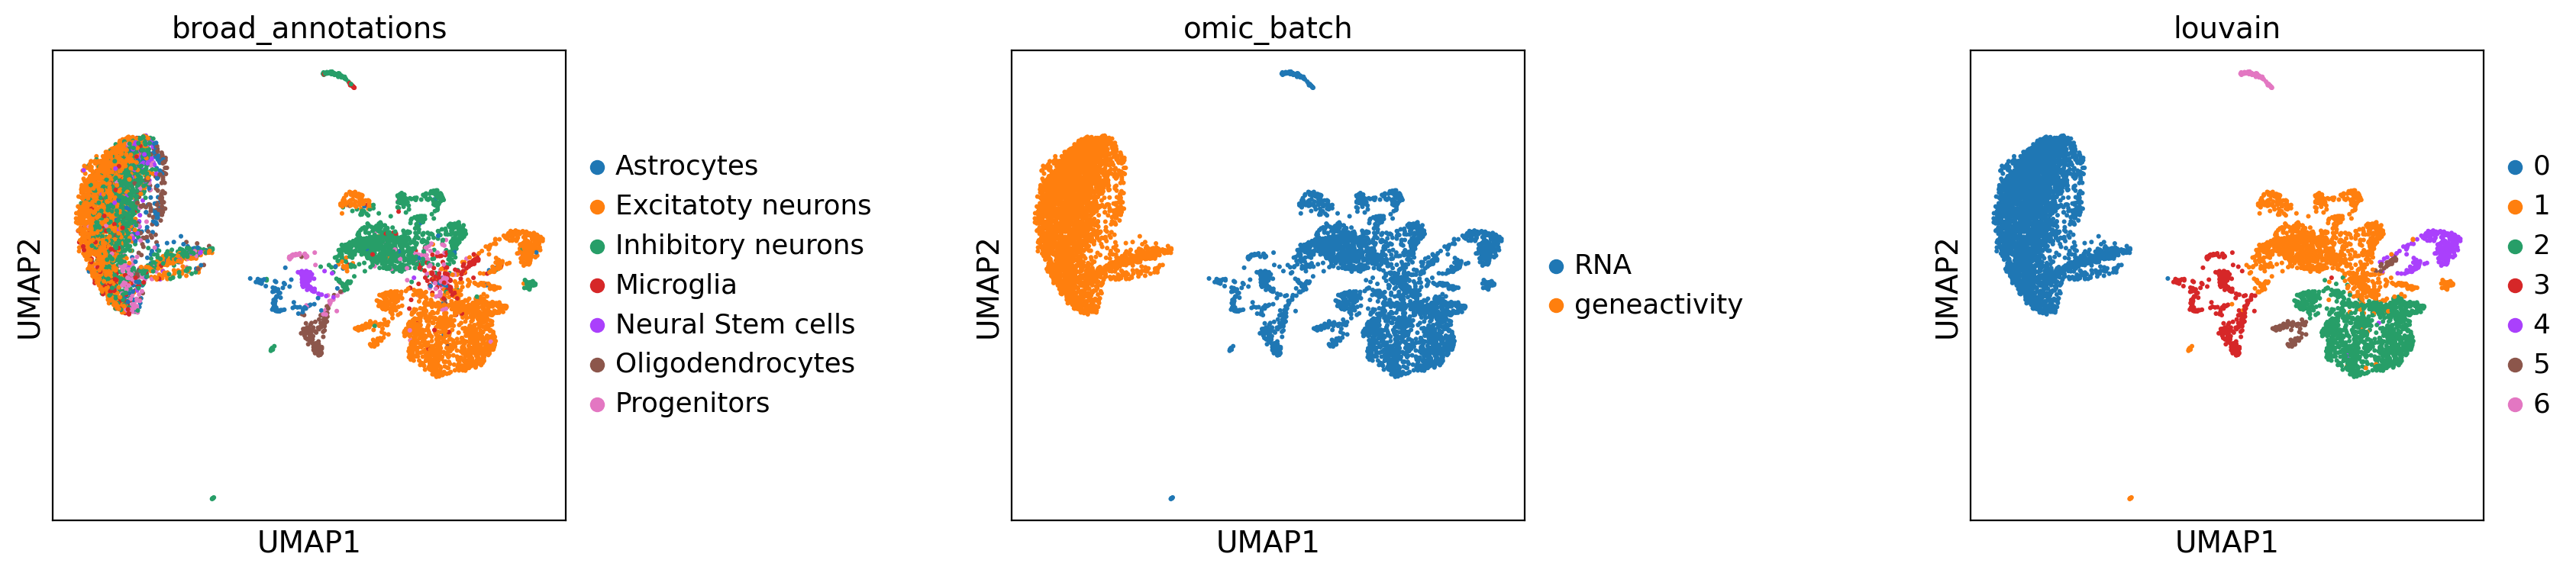

----------
liger


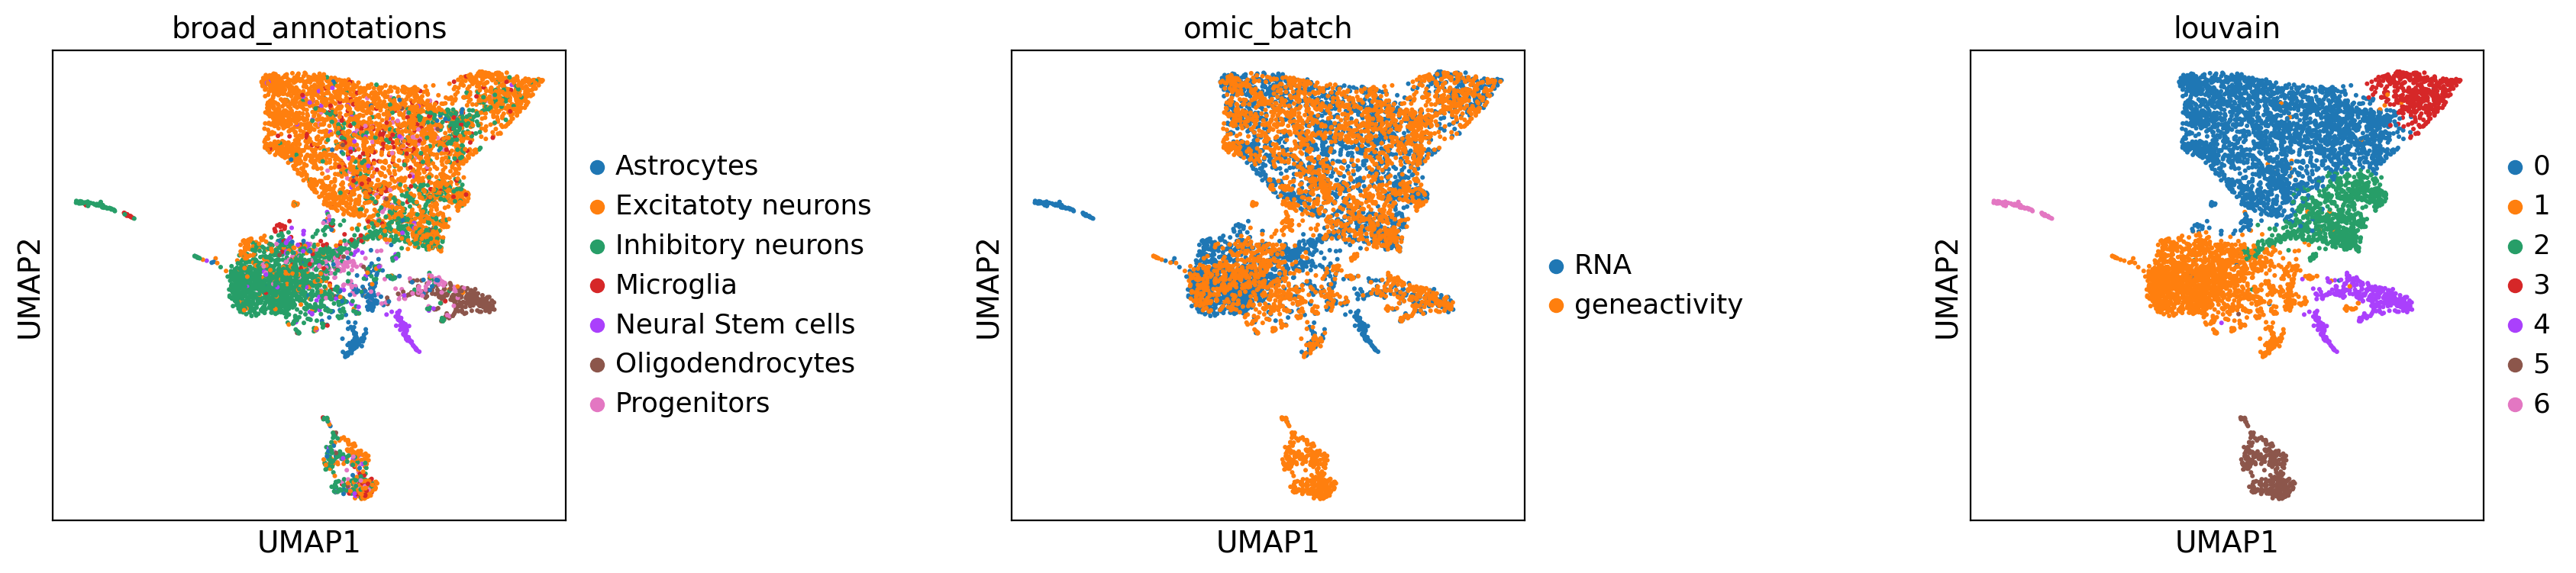

----------
scjoint


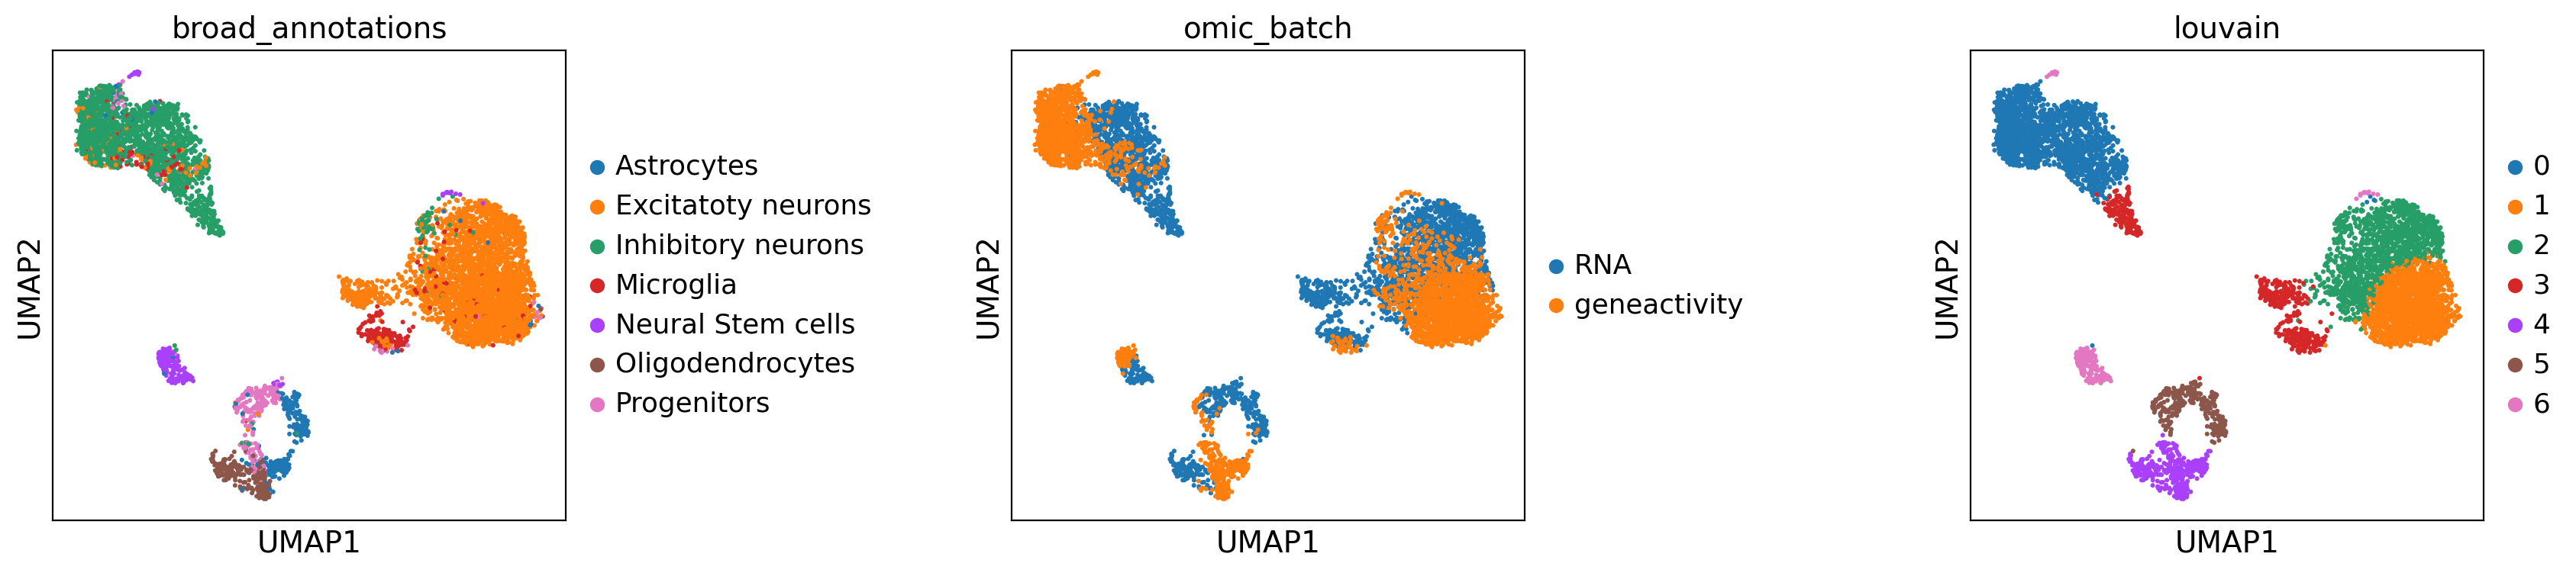

----------
seurat_cca


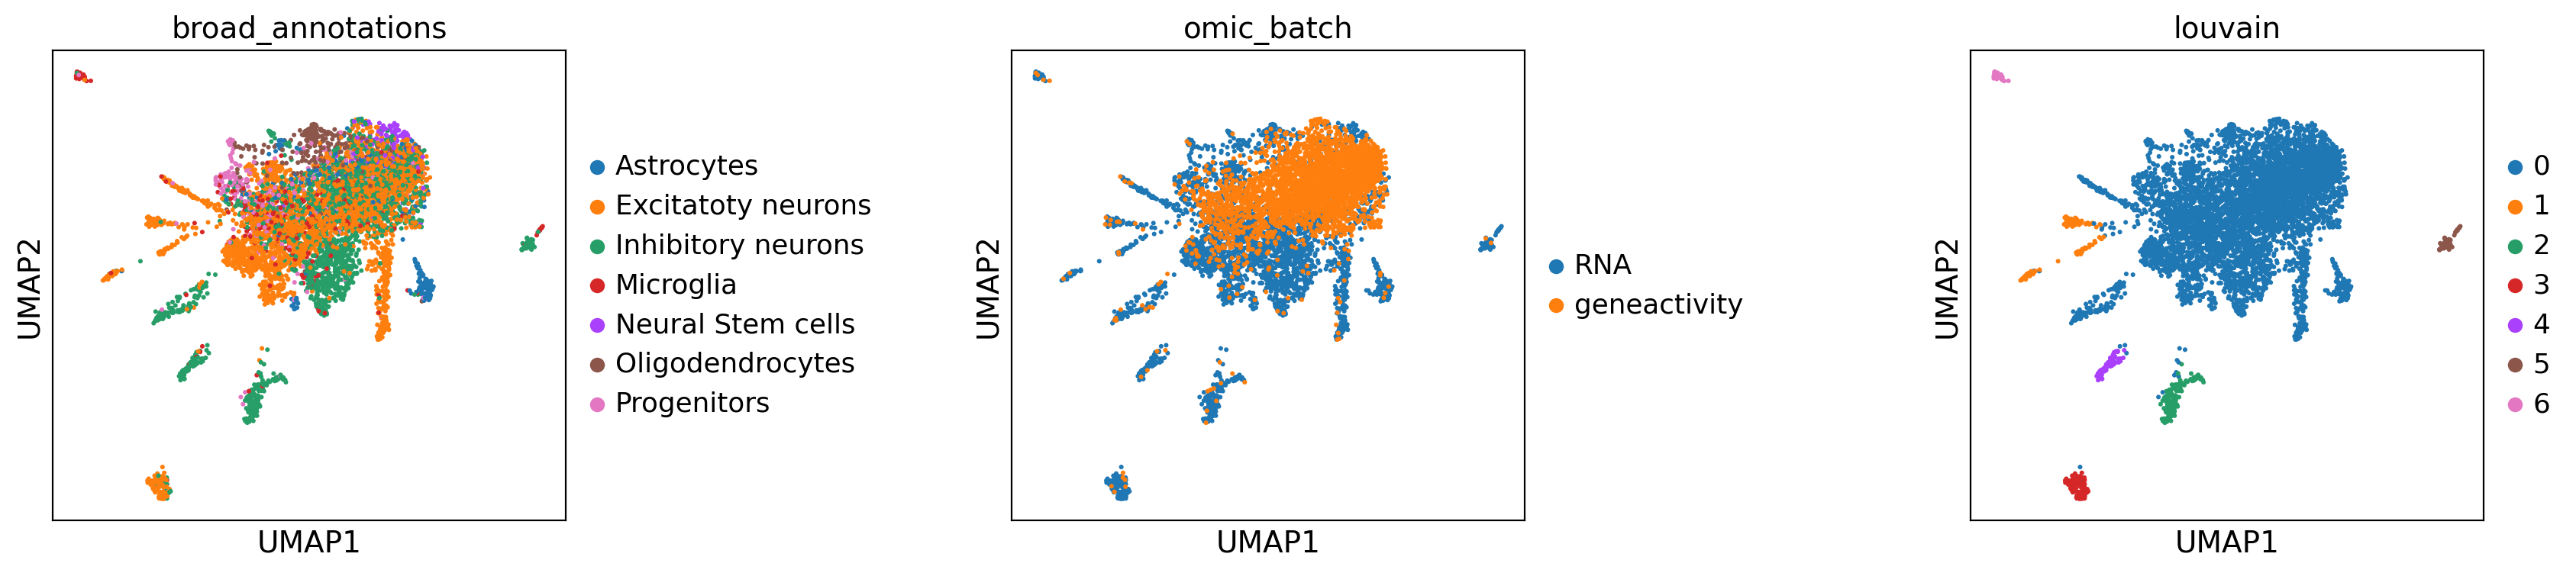

----------
seurat_rpca


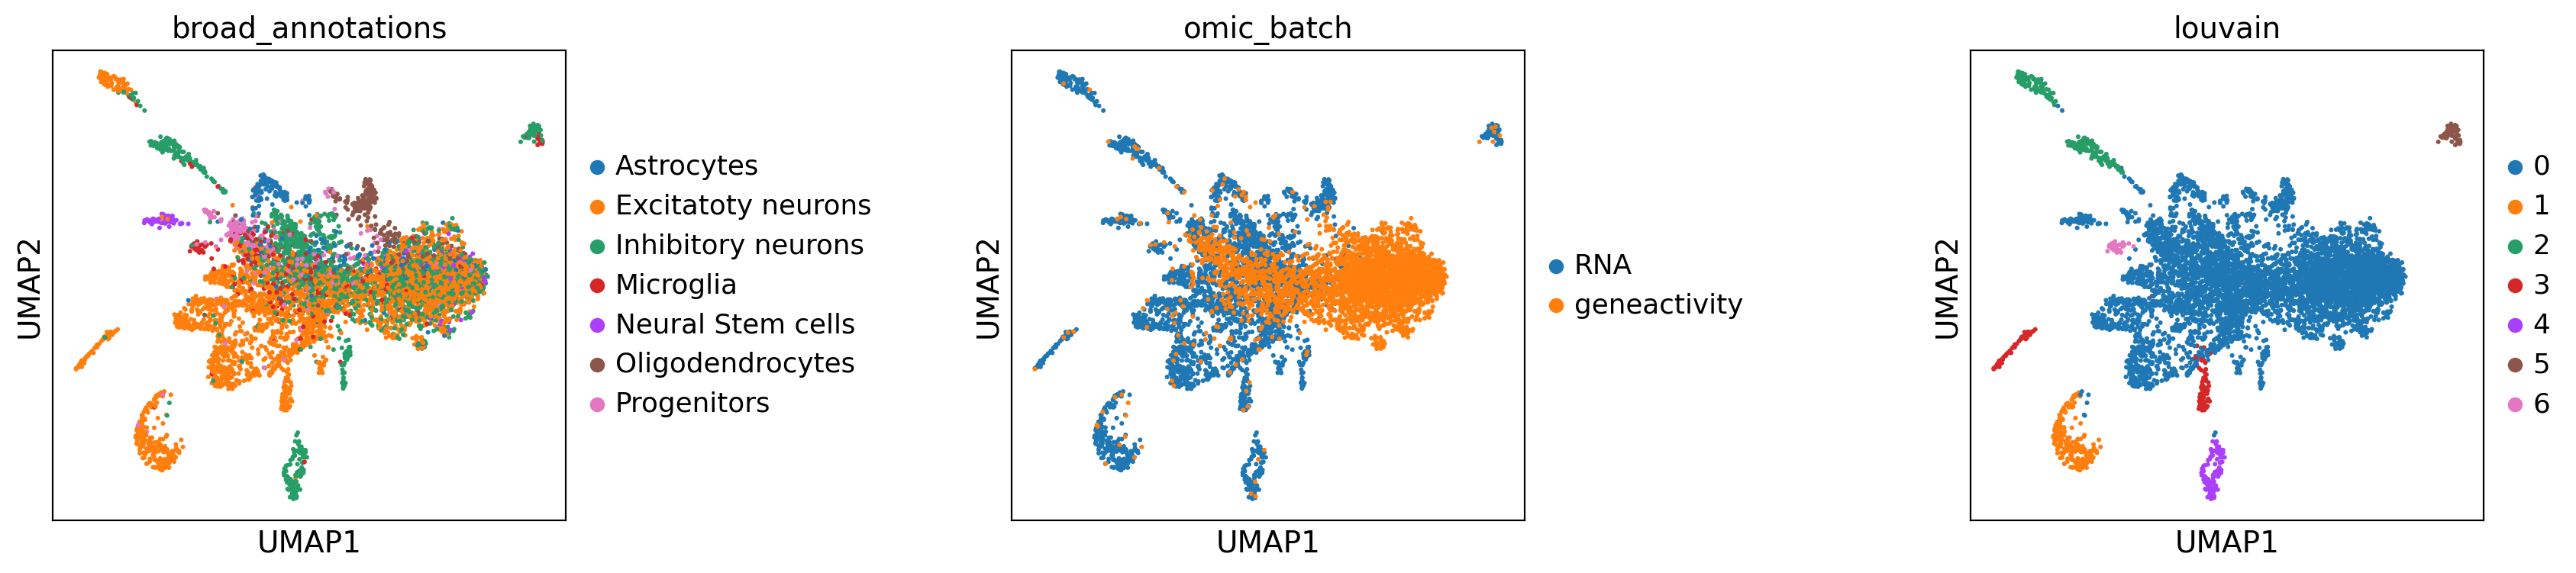

----------
scalex


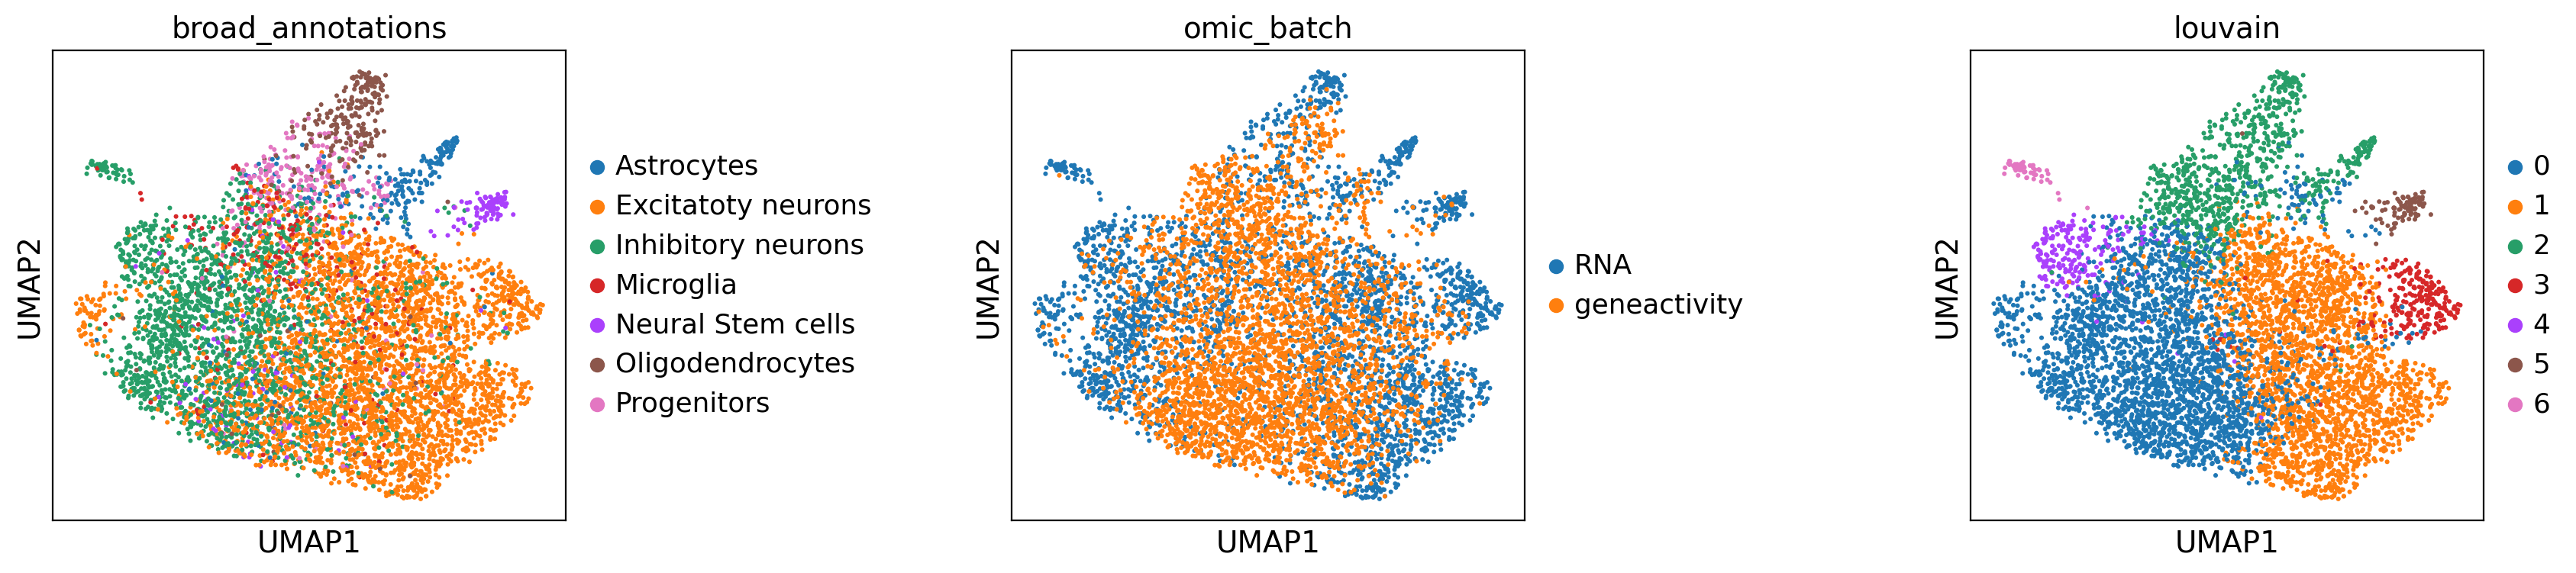

----------
scot


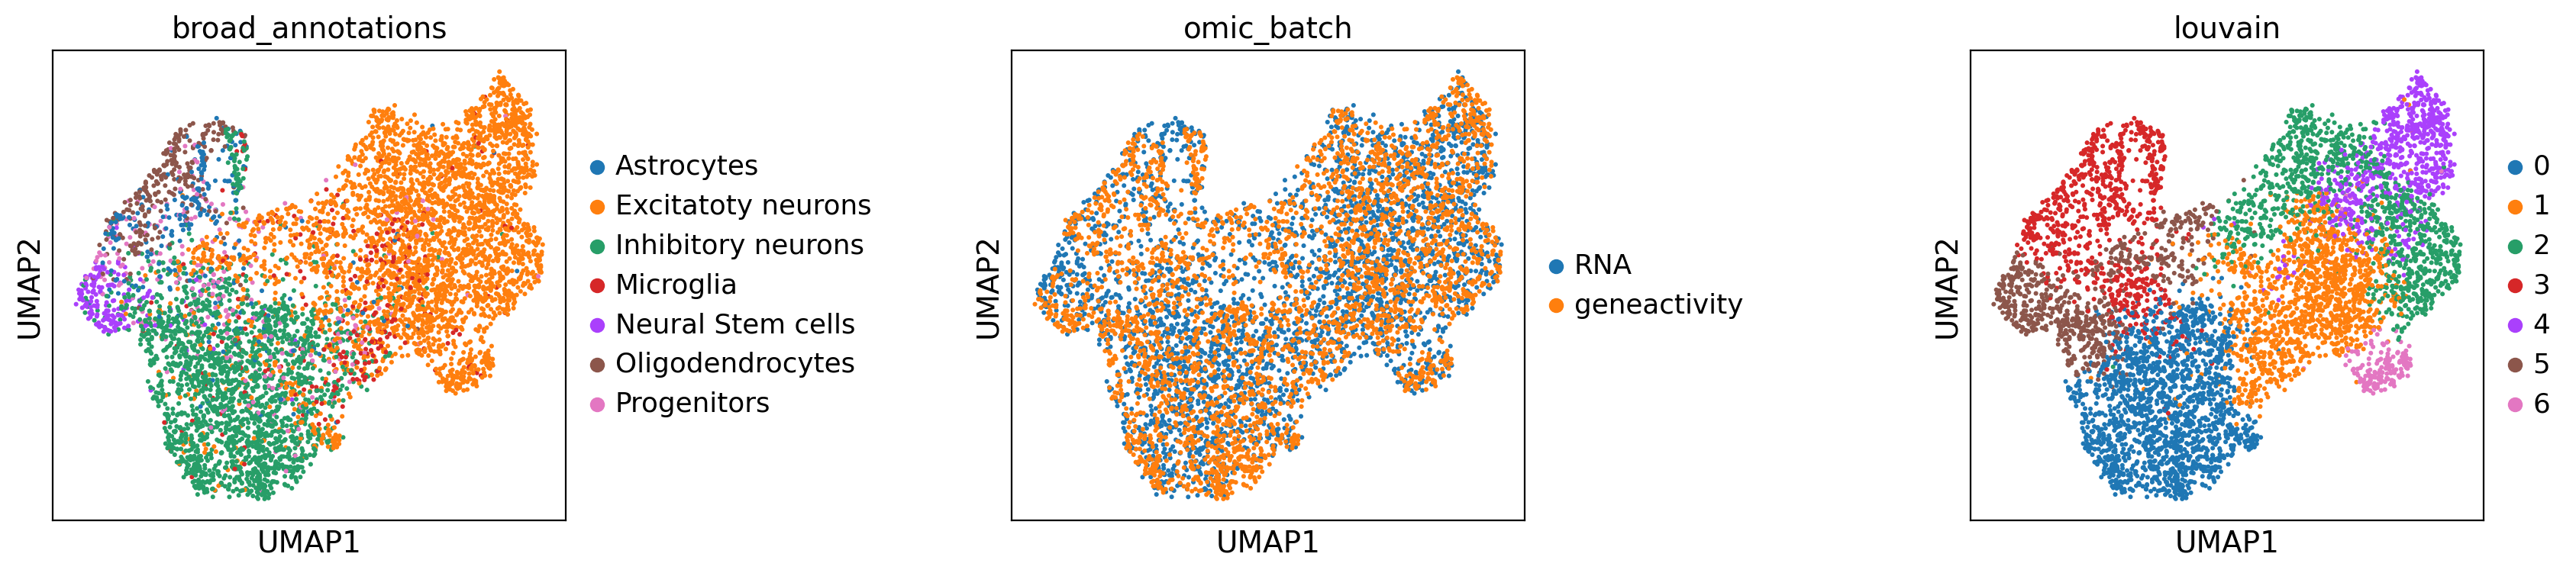

In [9]:
for i,j in zip(adata_list, ids):
    print('-' * 10)
    print(j)
    sc.pl.umap(i, color=[cell_type_col, 'omic_batch', 'louvain'], wspace=0.7)

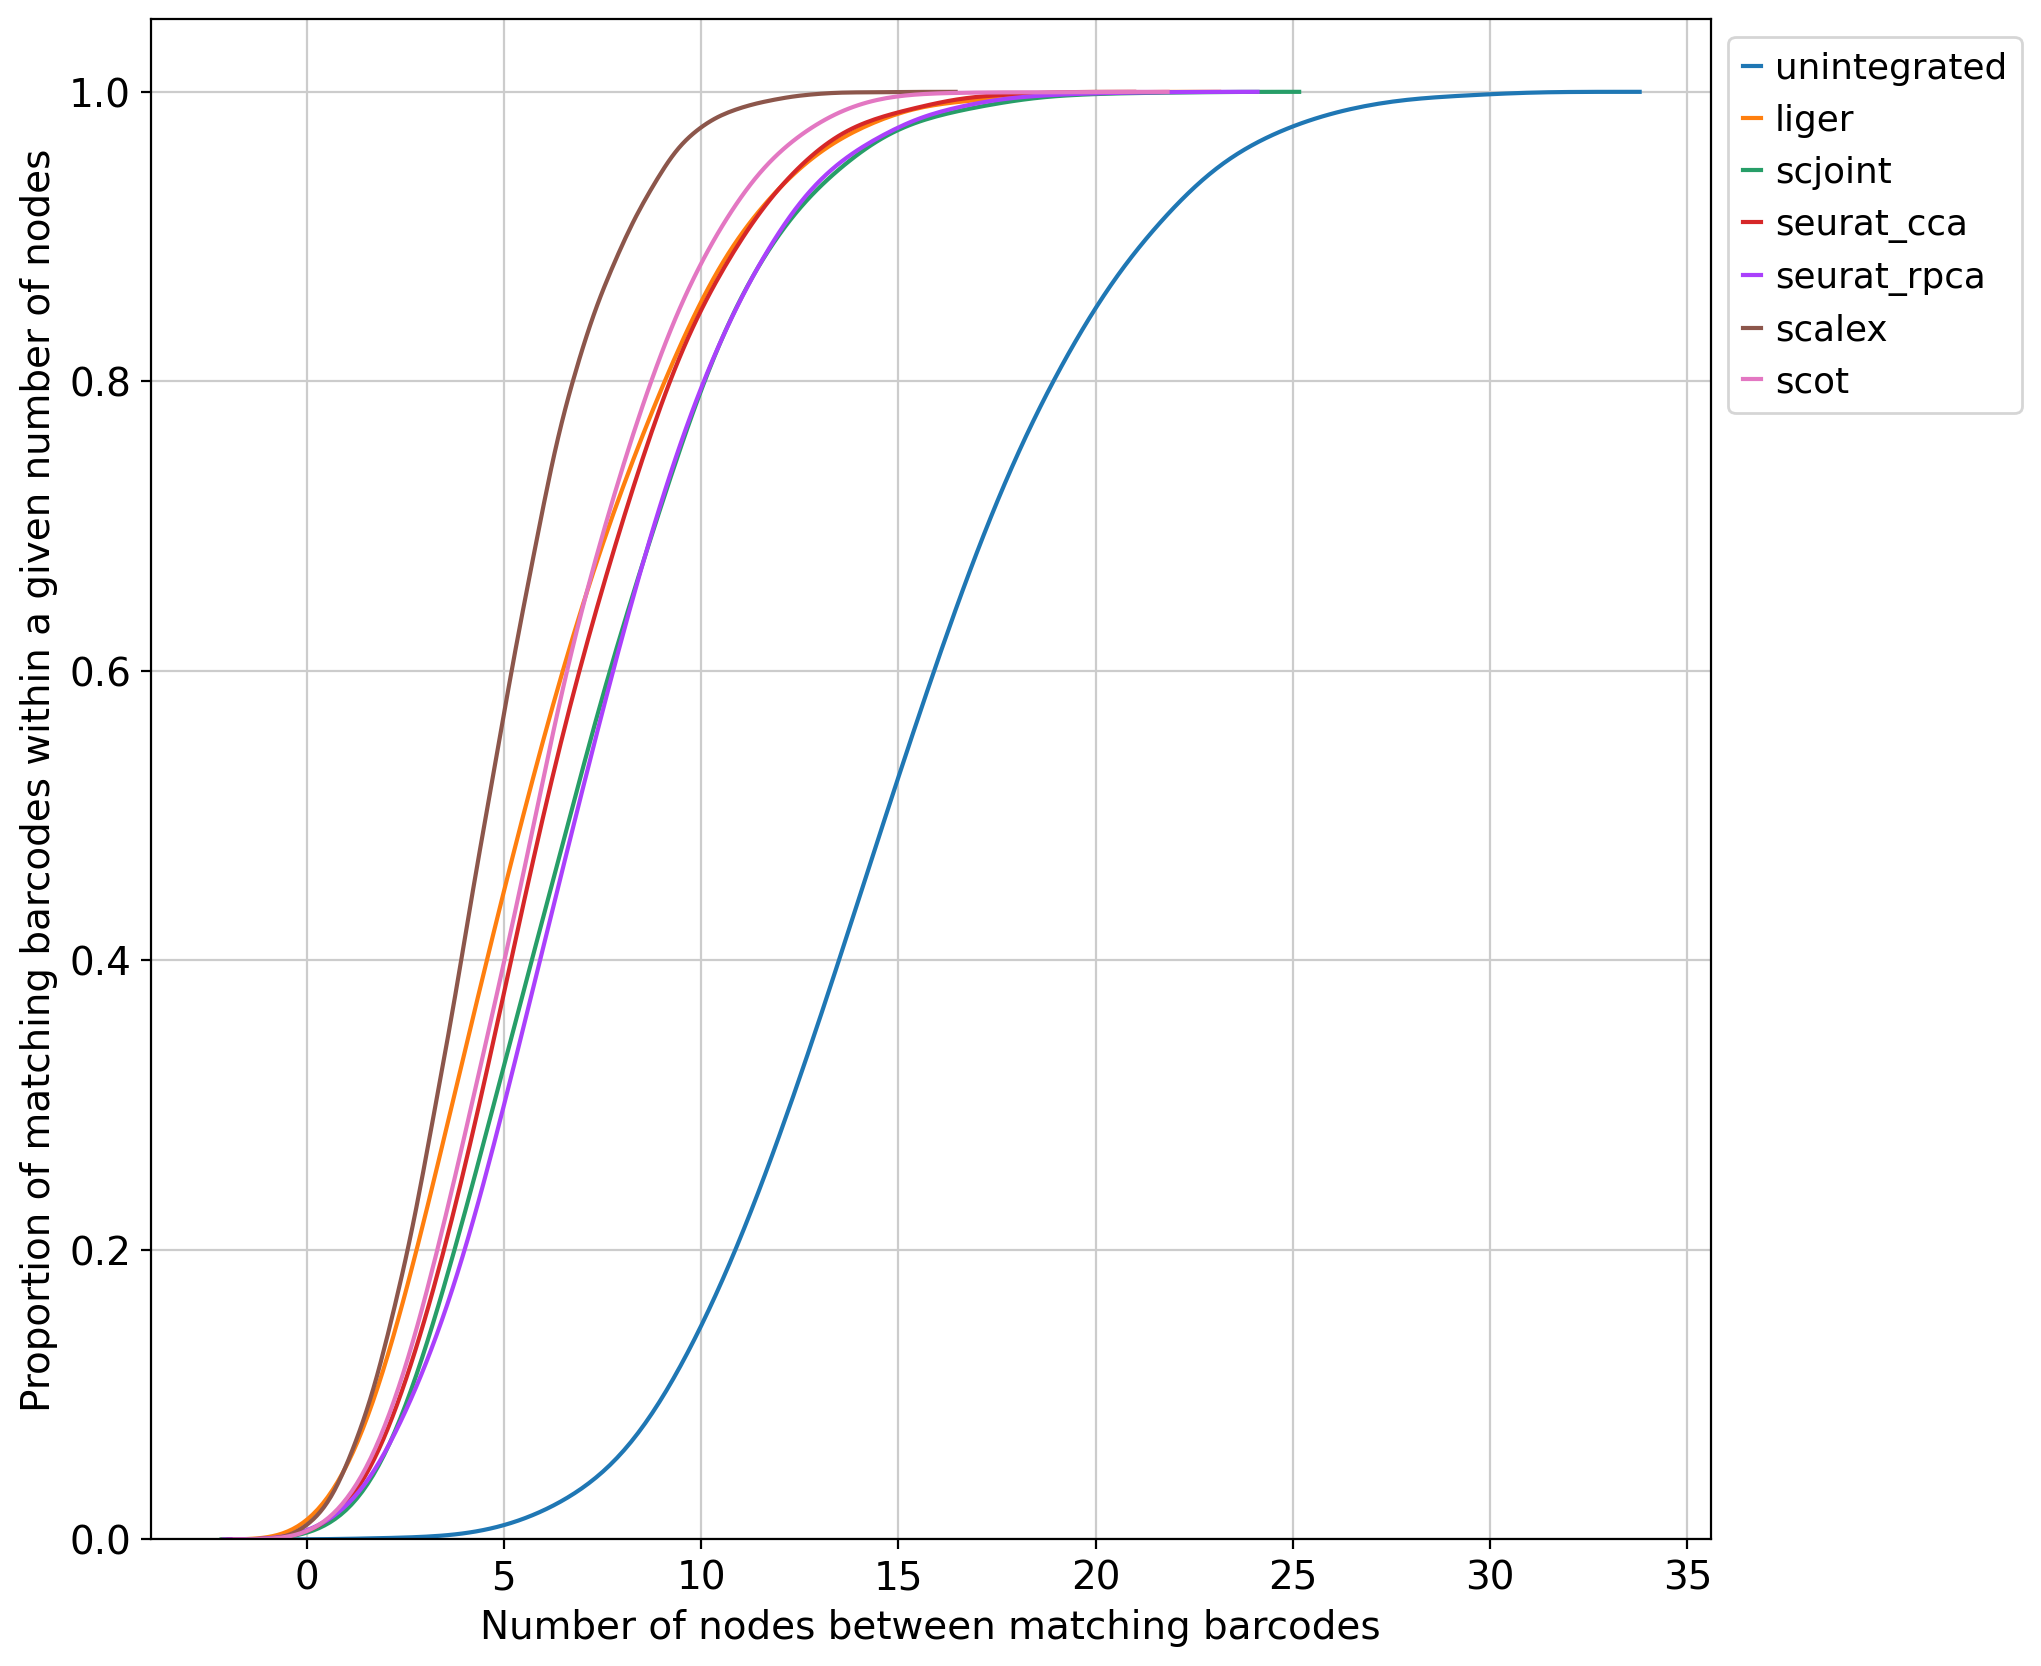

In [10]:
scmoib.pl.cumulative_node_group(adata_list, ids)

unintegrated


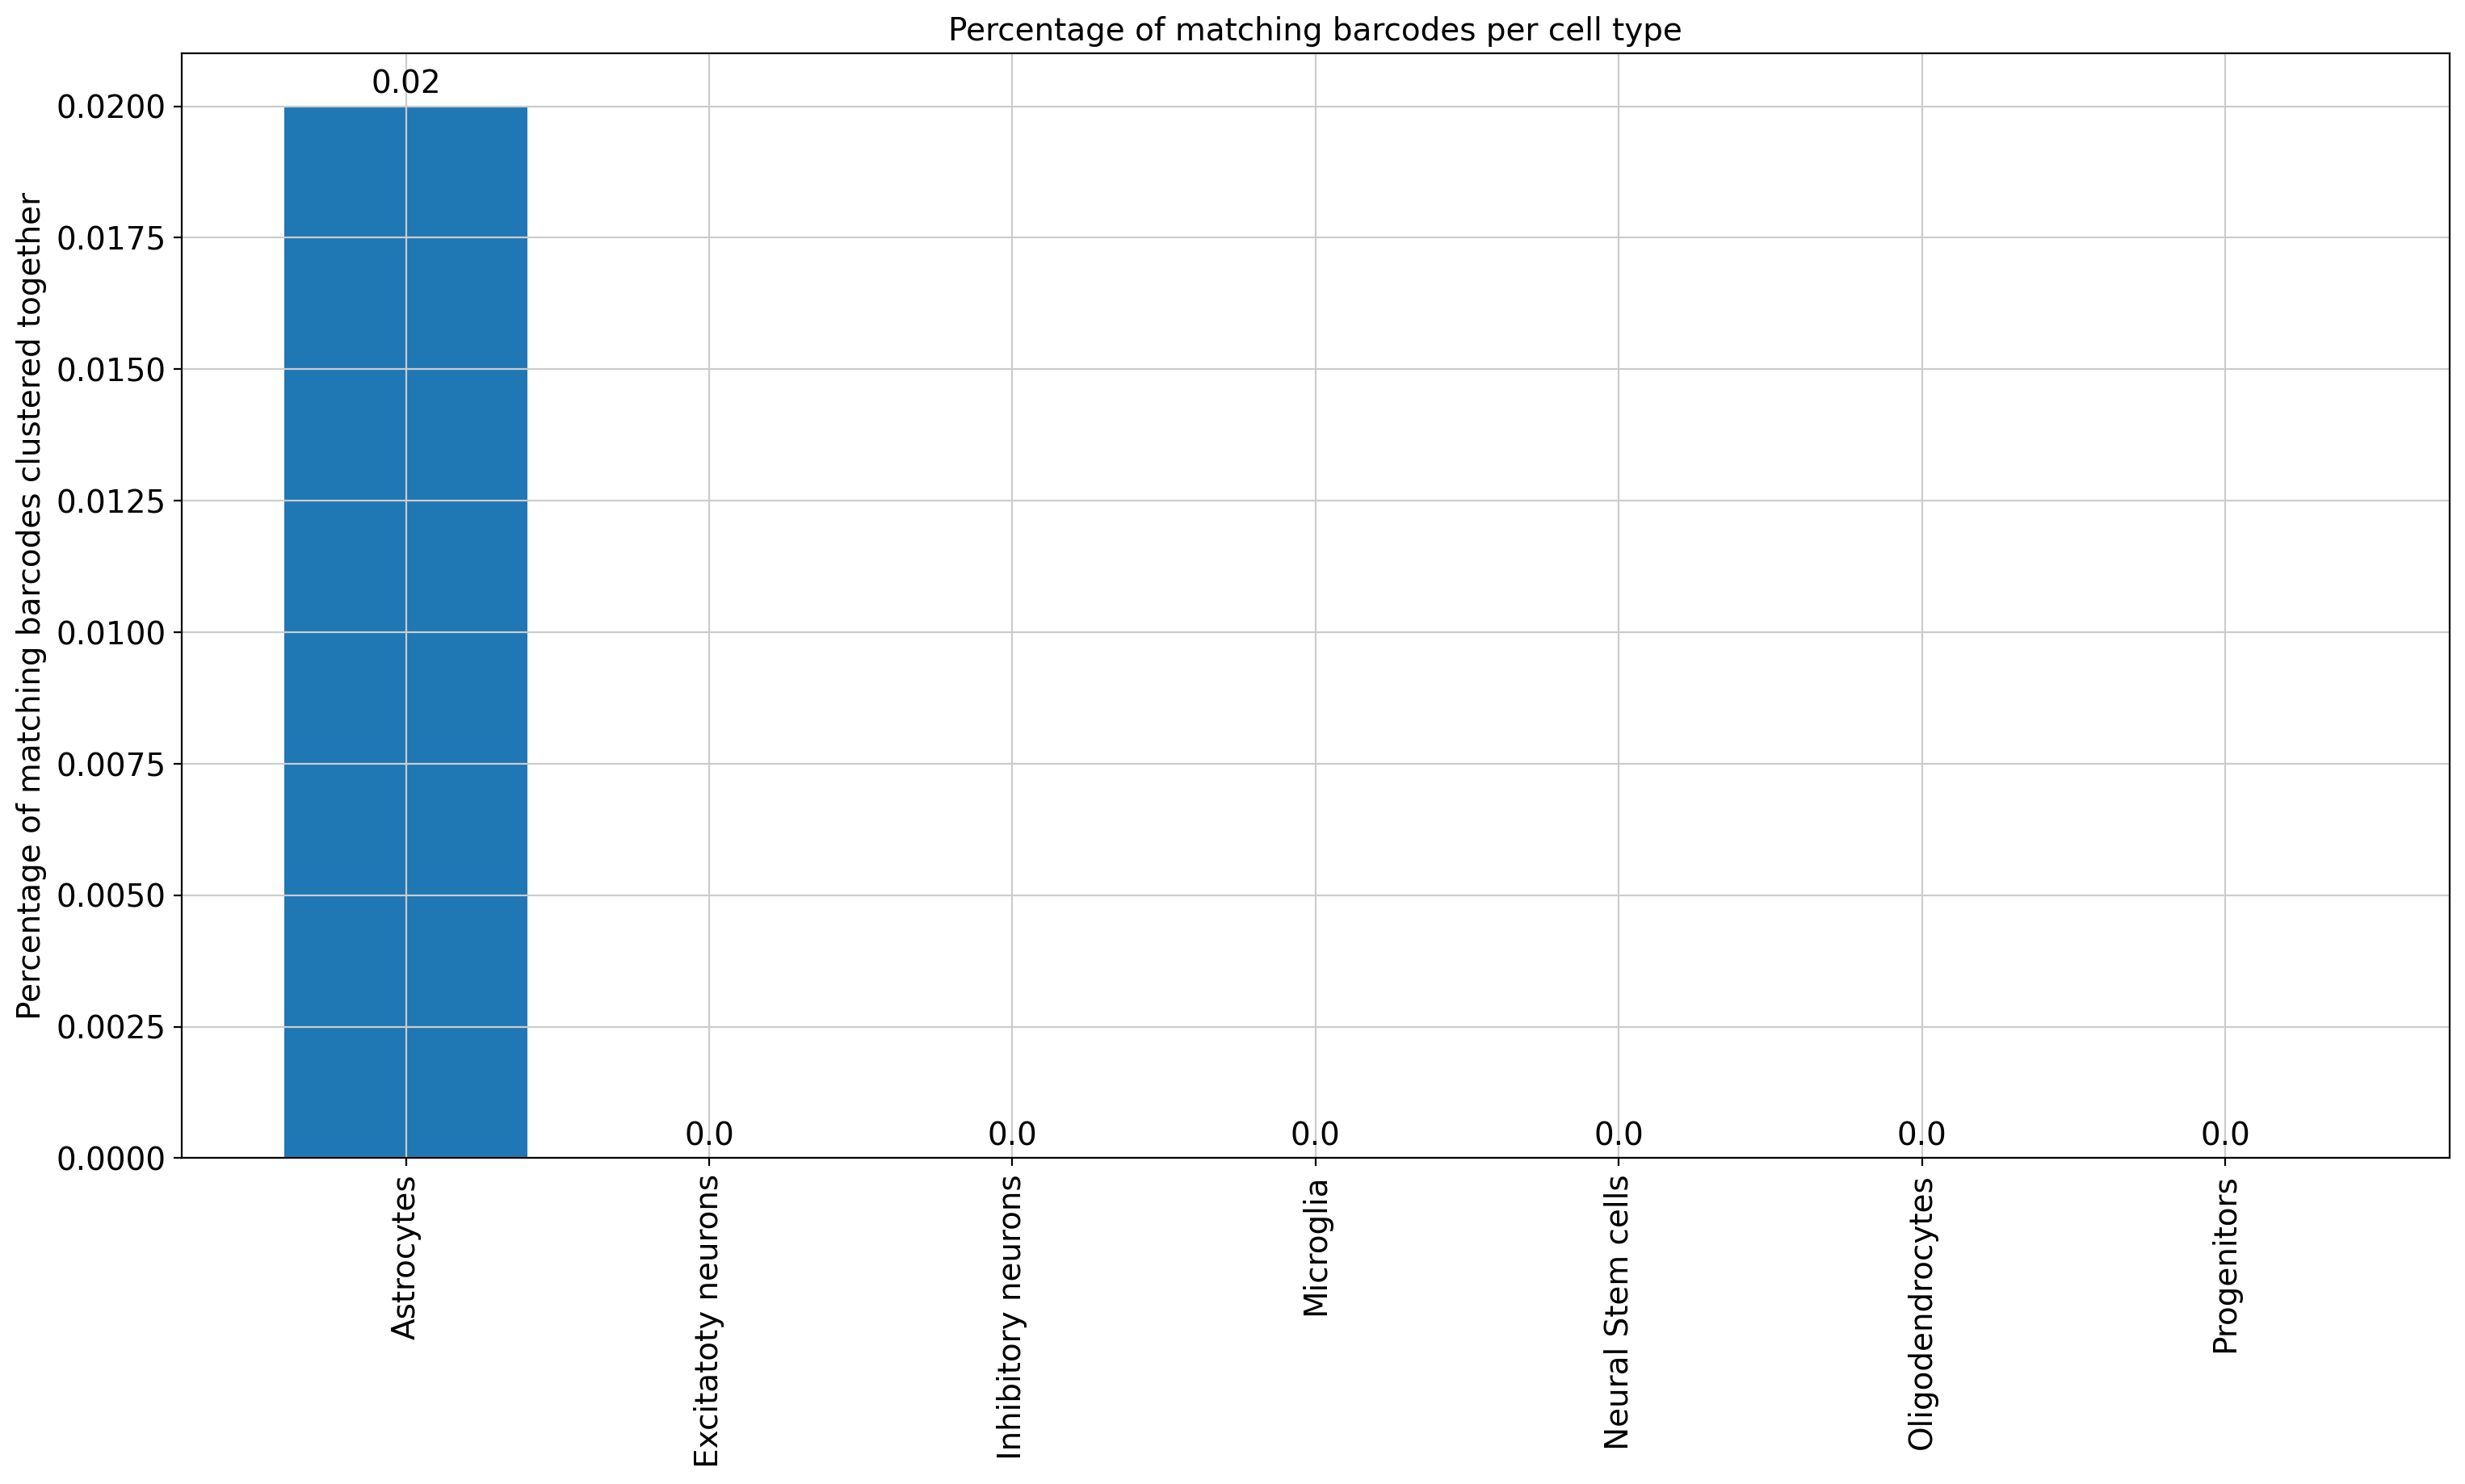

liger


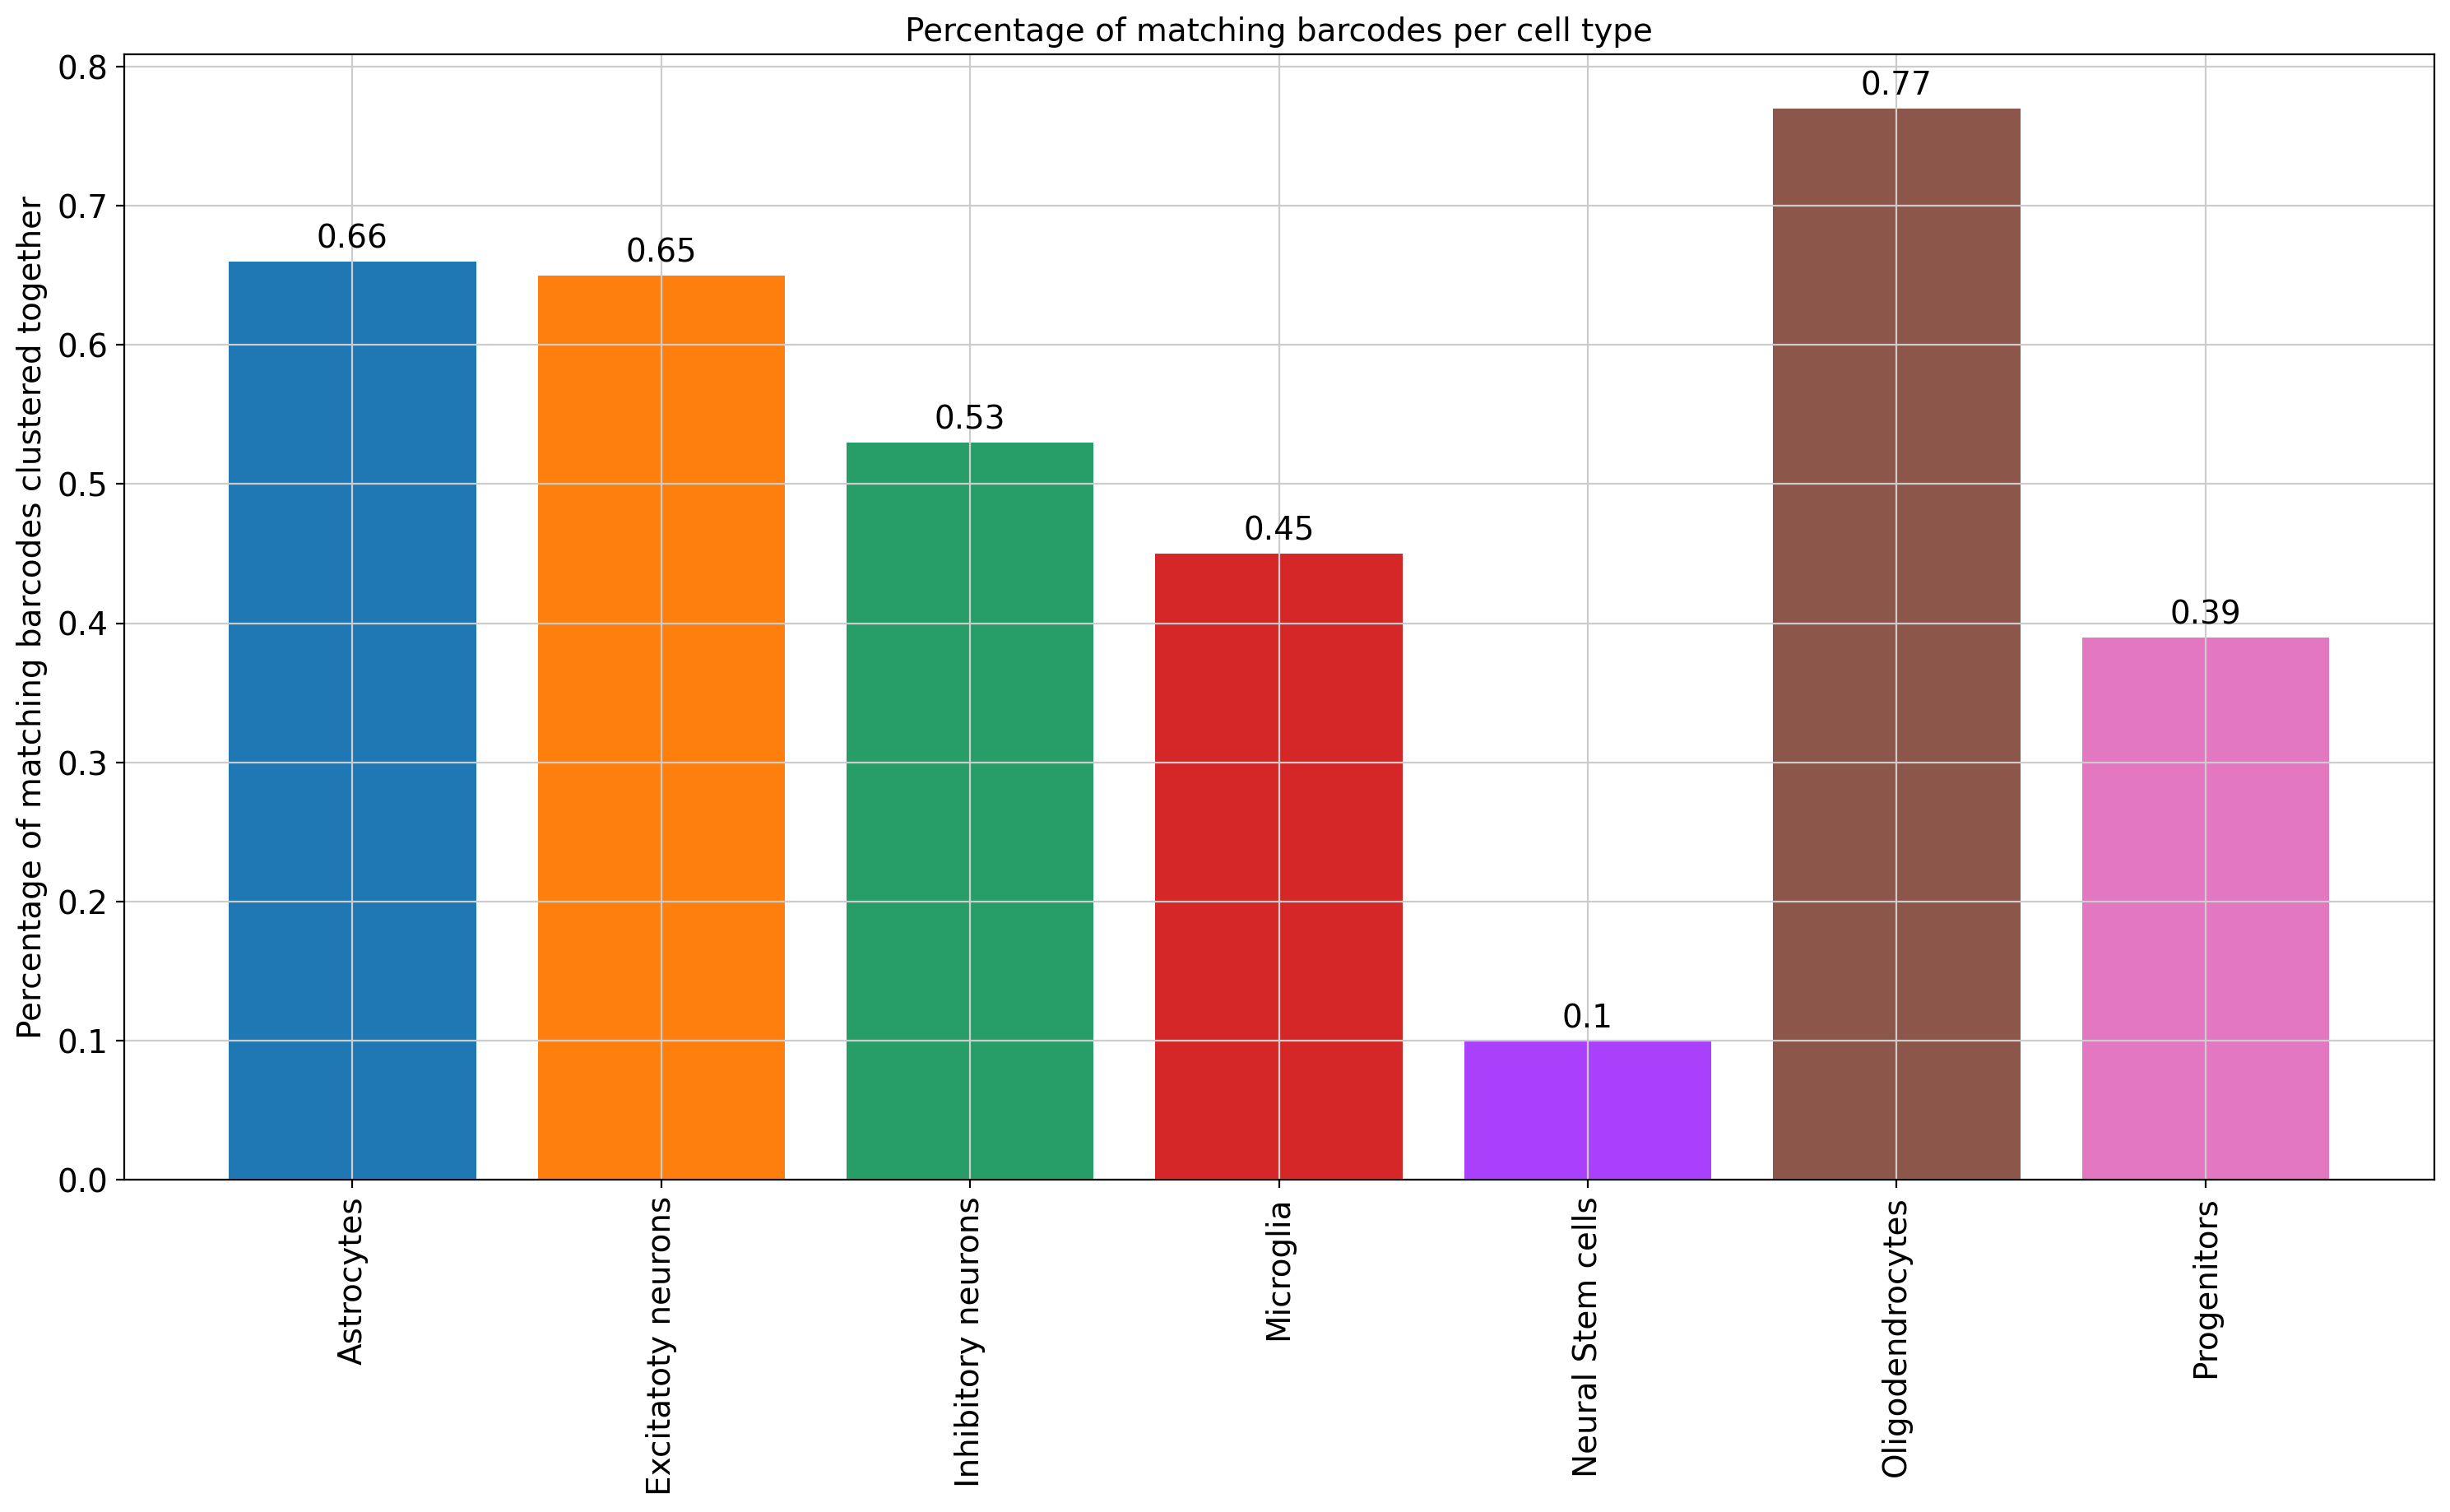

scjoint


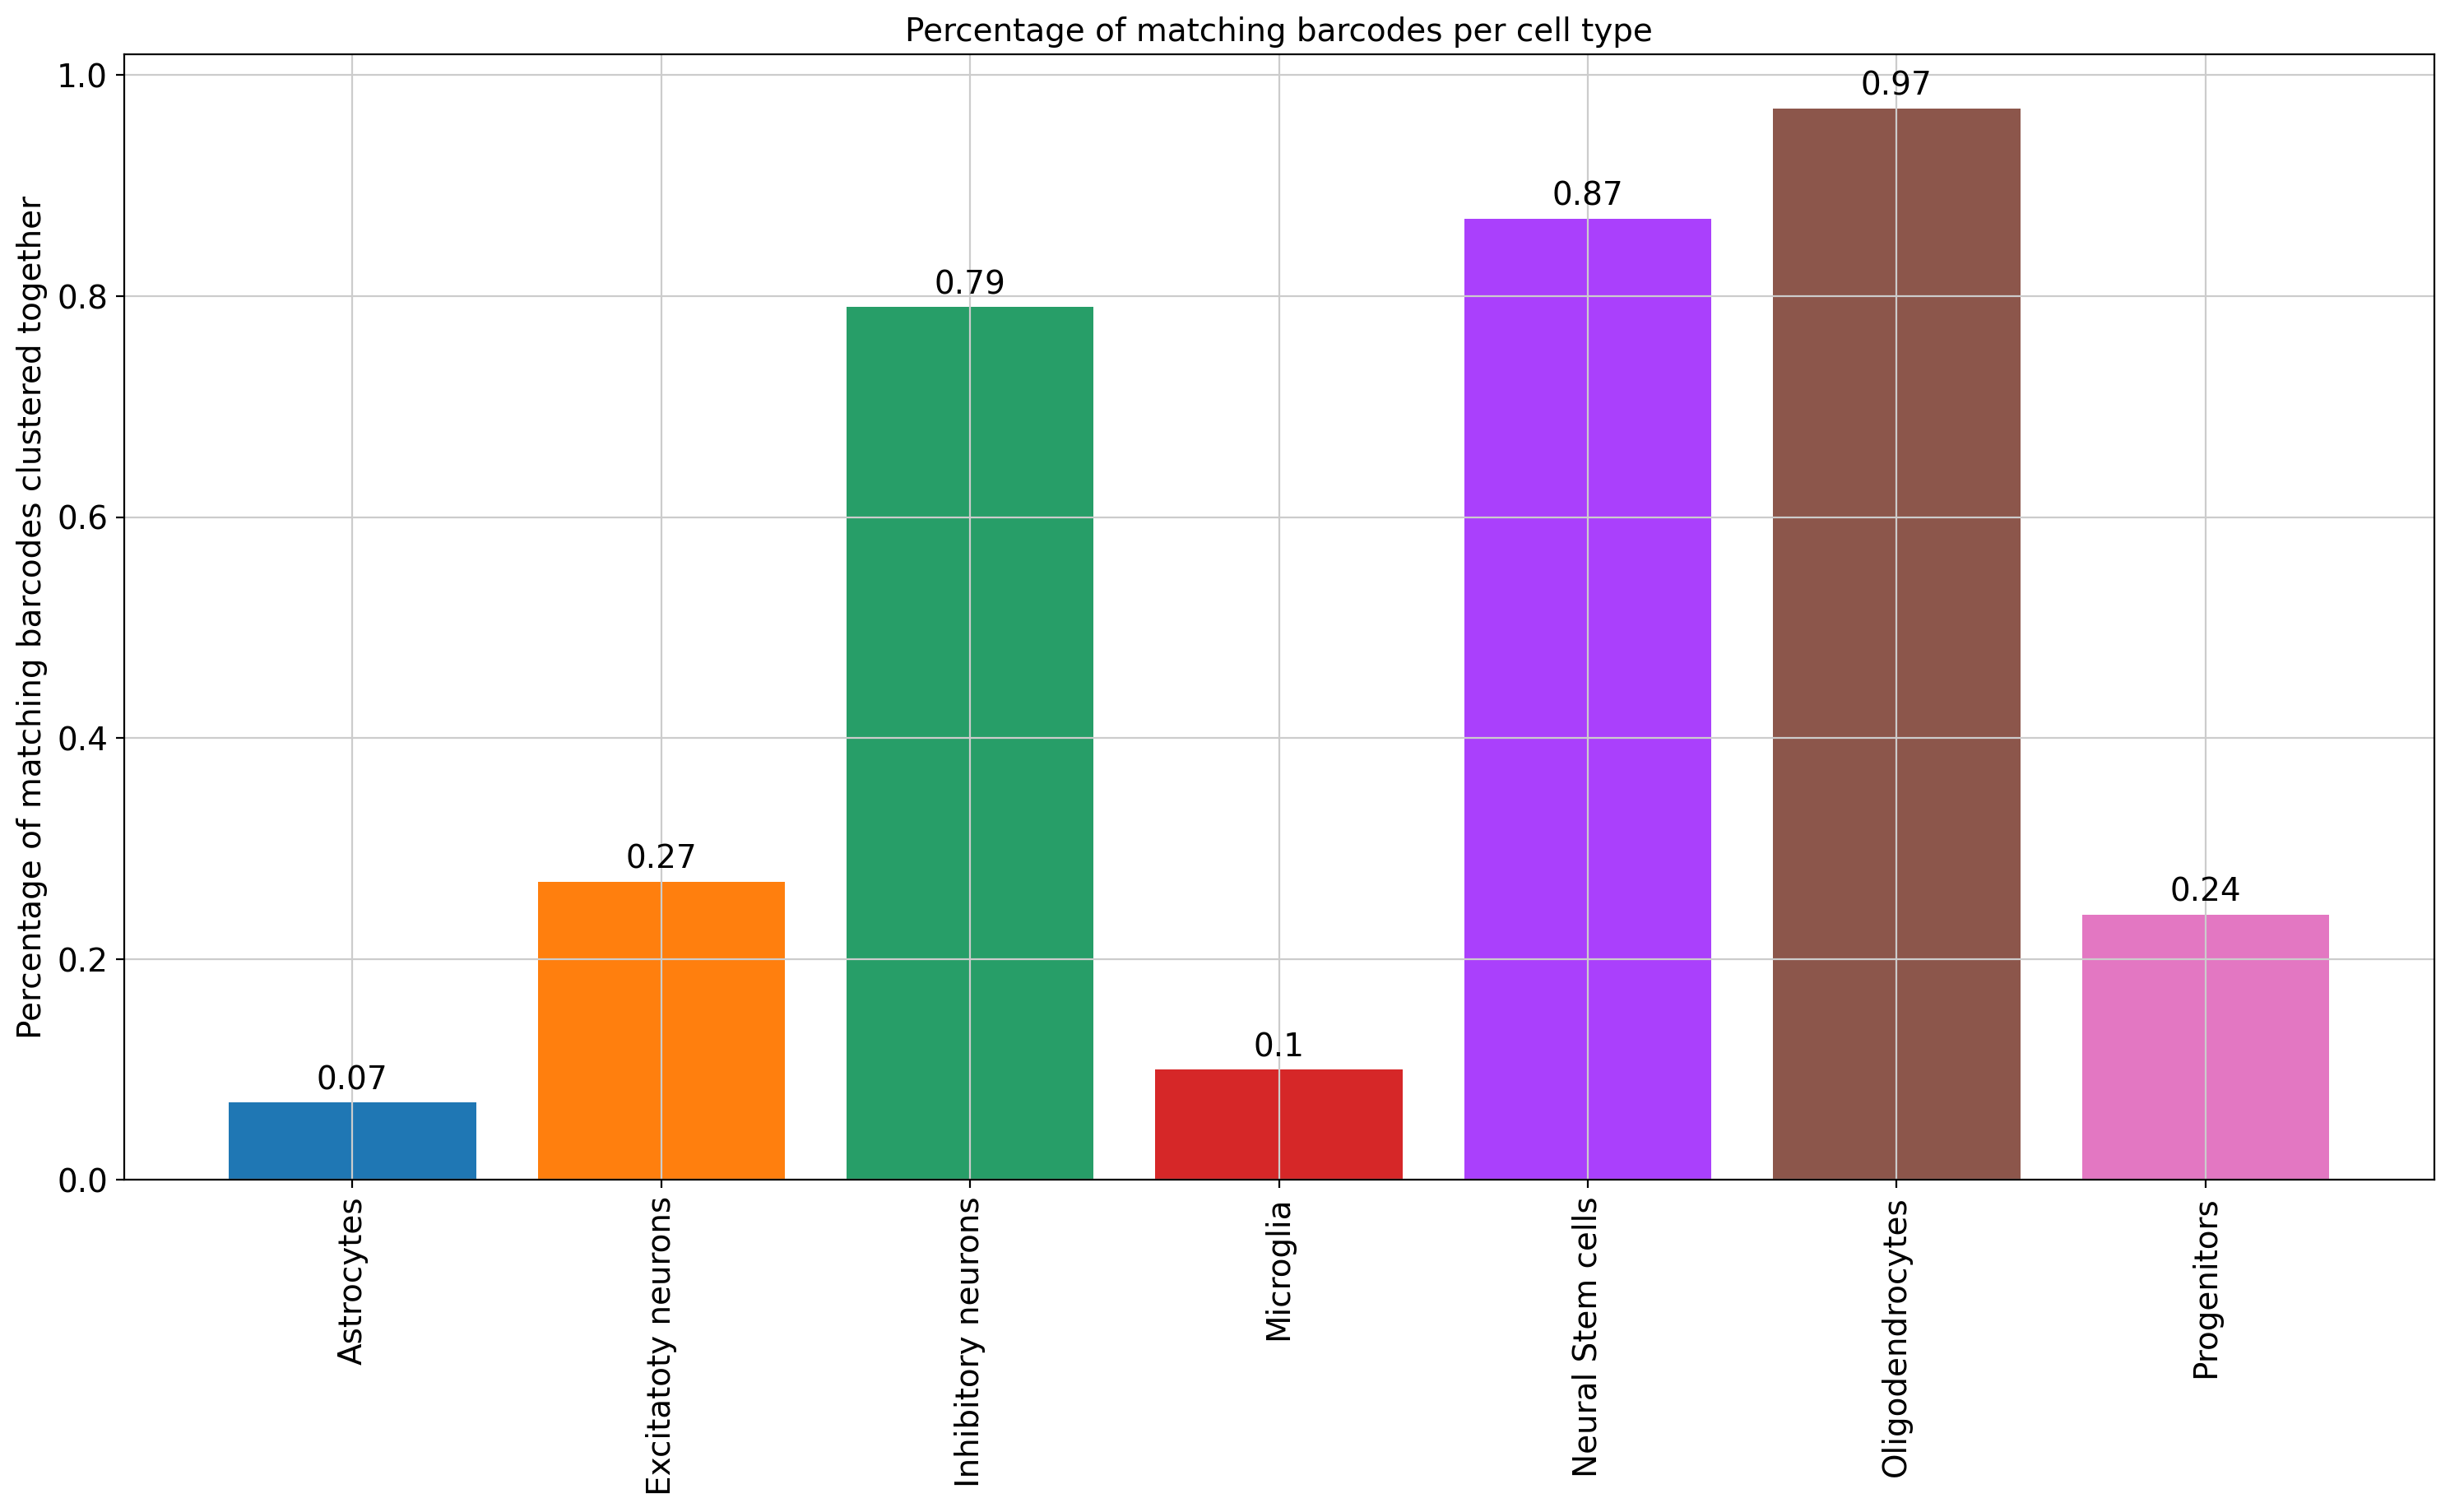

seurat_cca


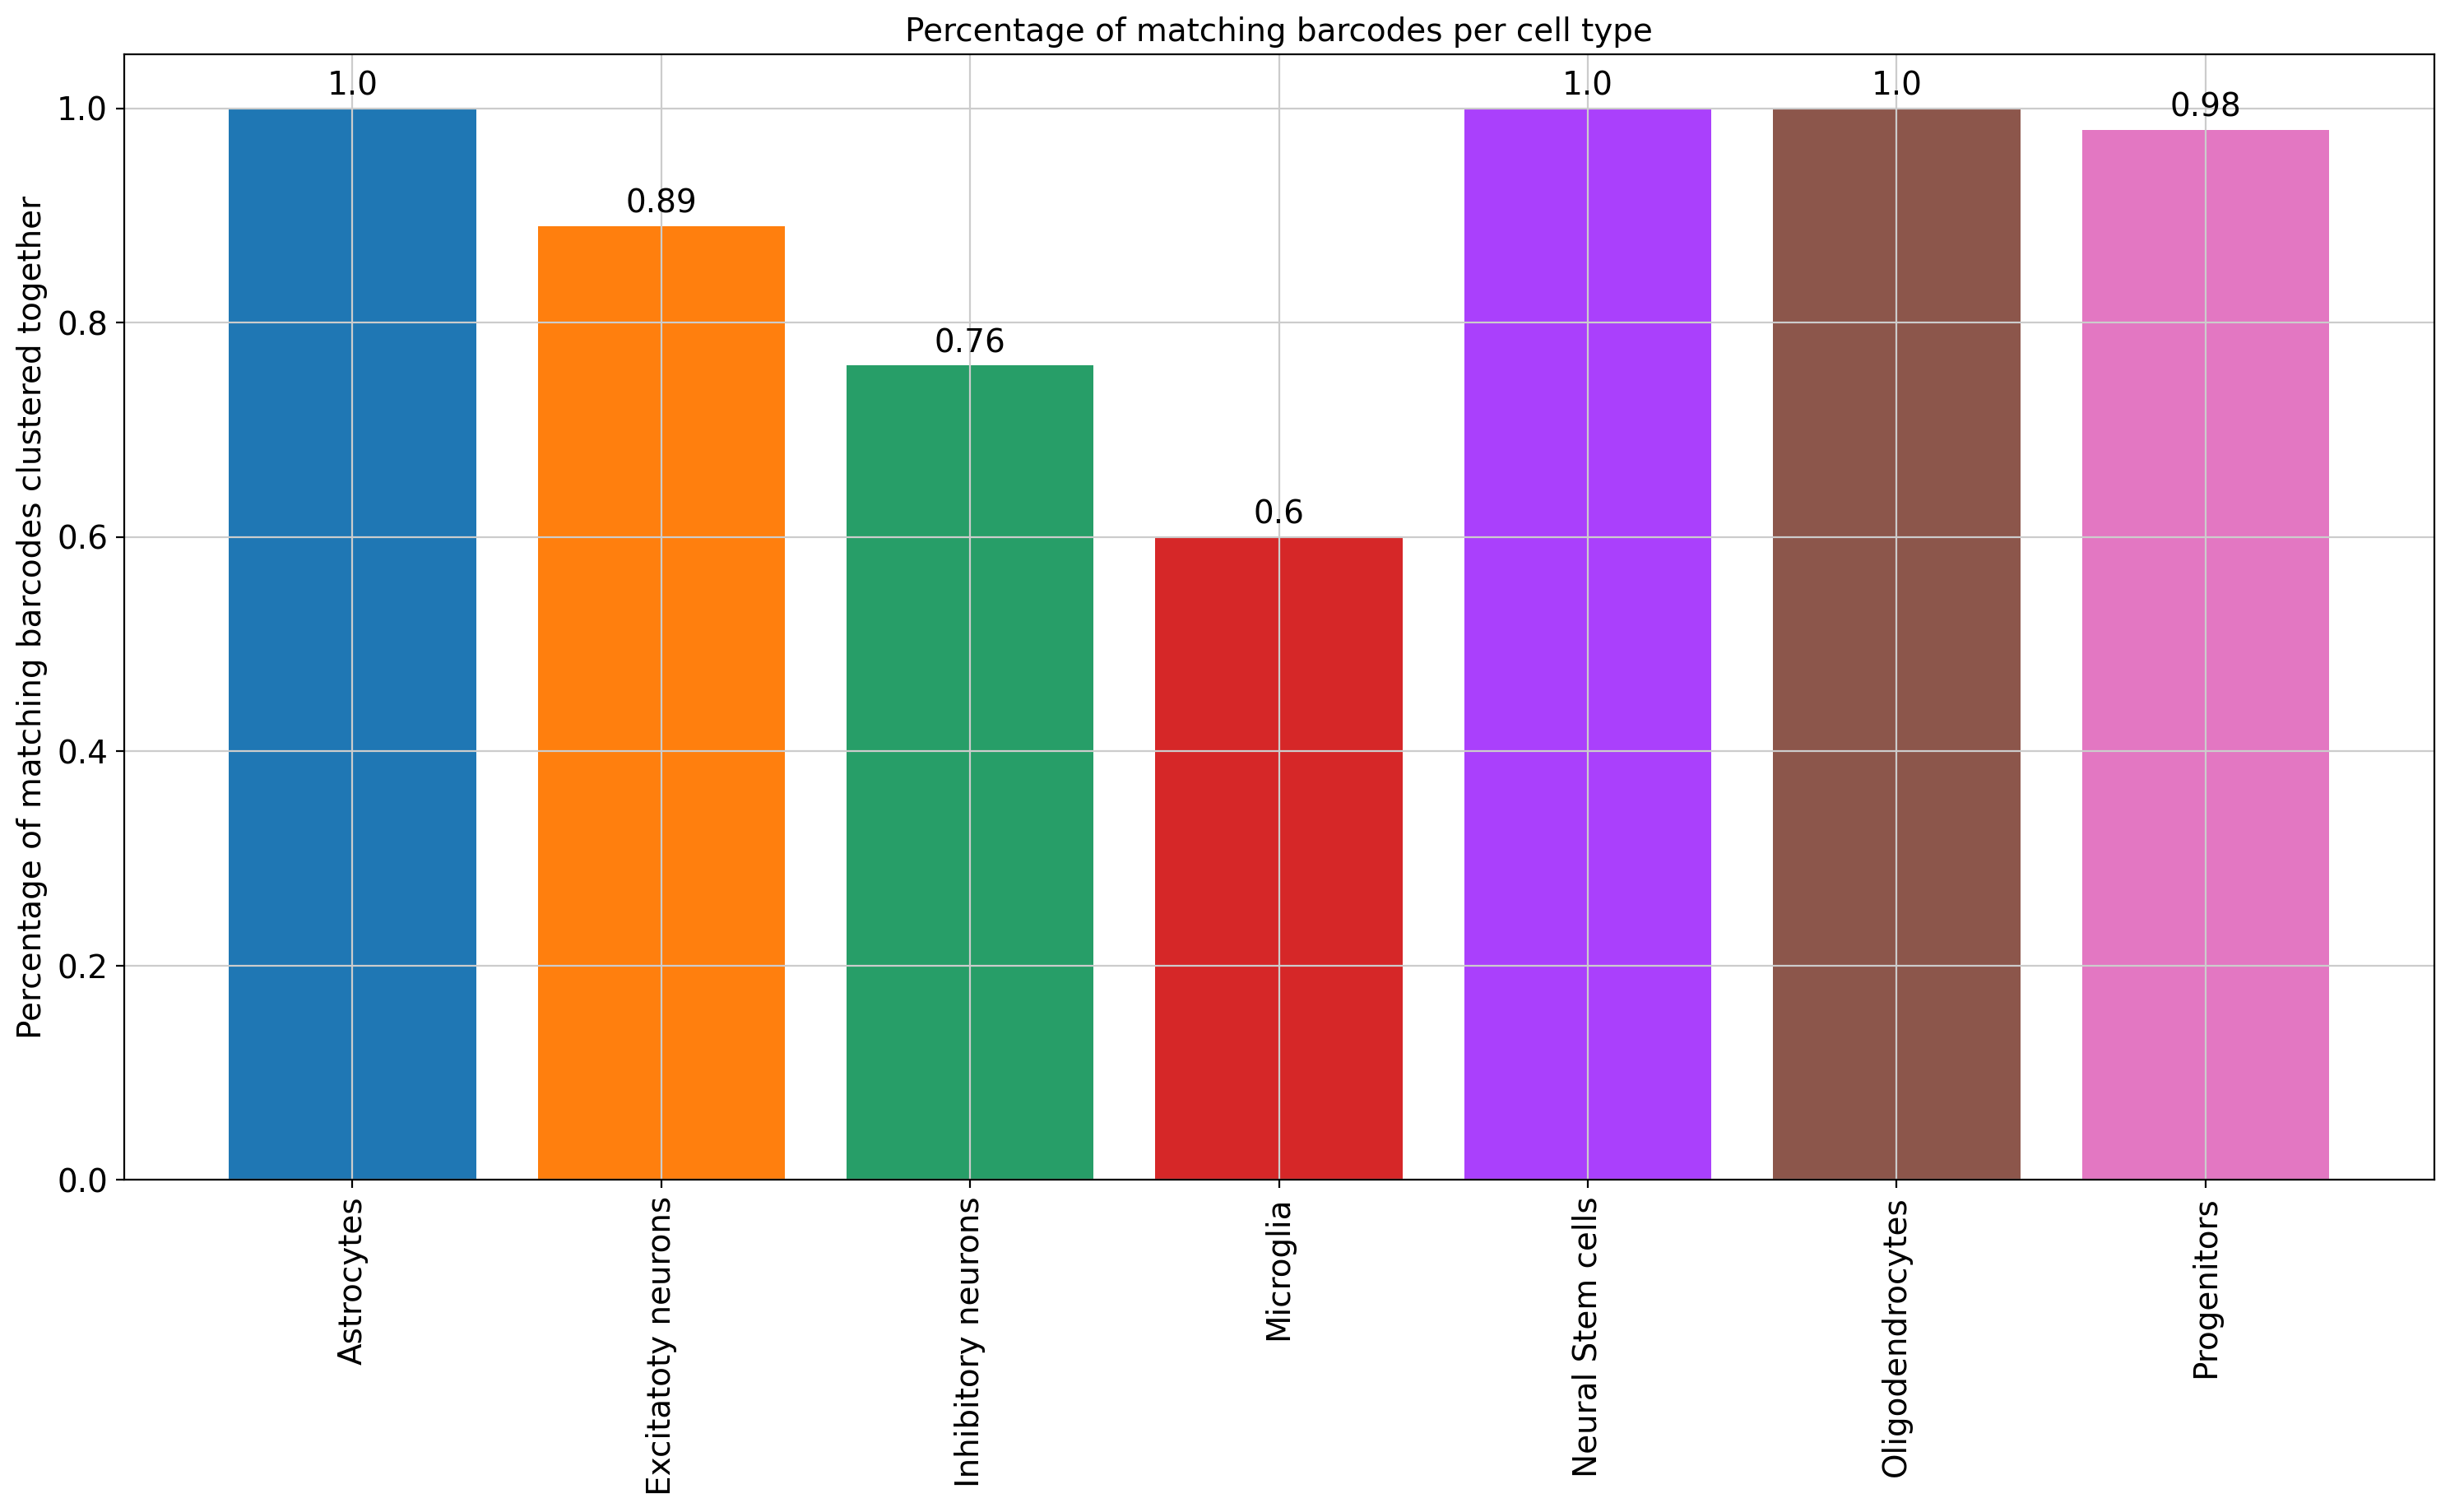

seurat_rpca


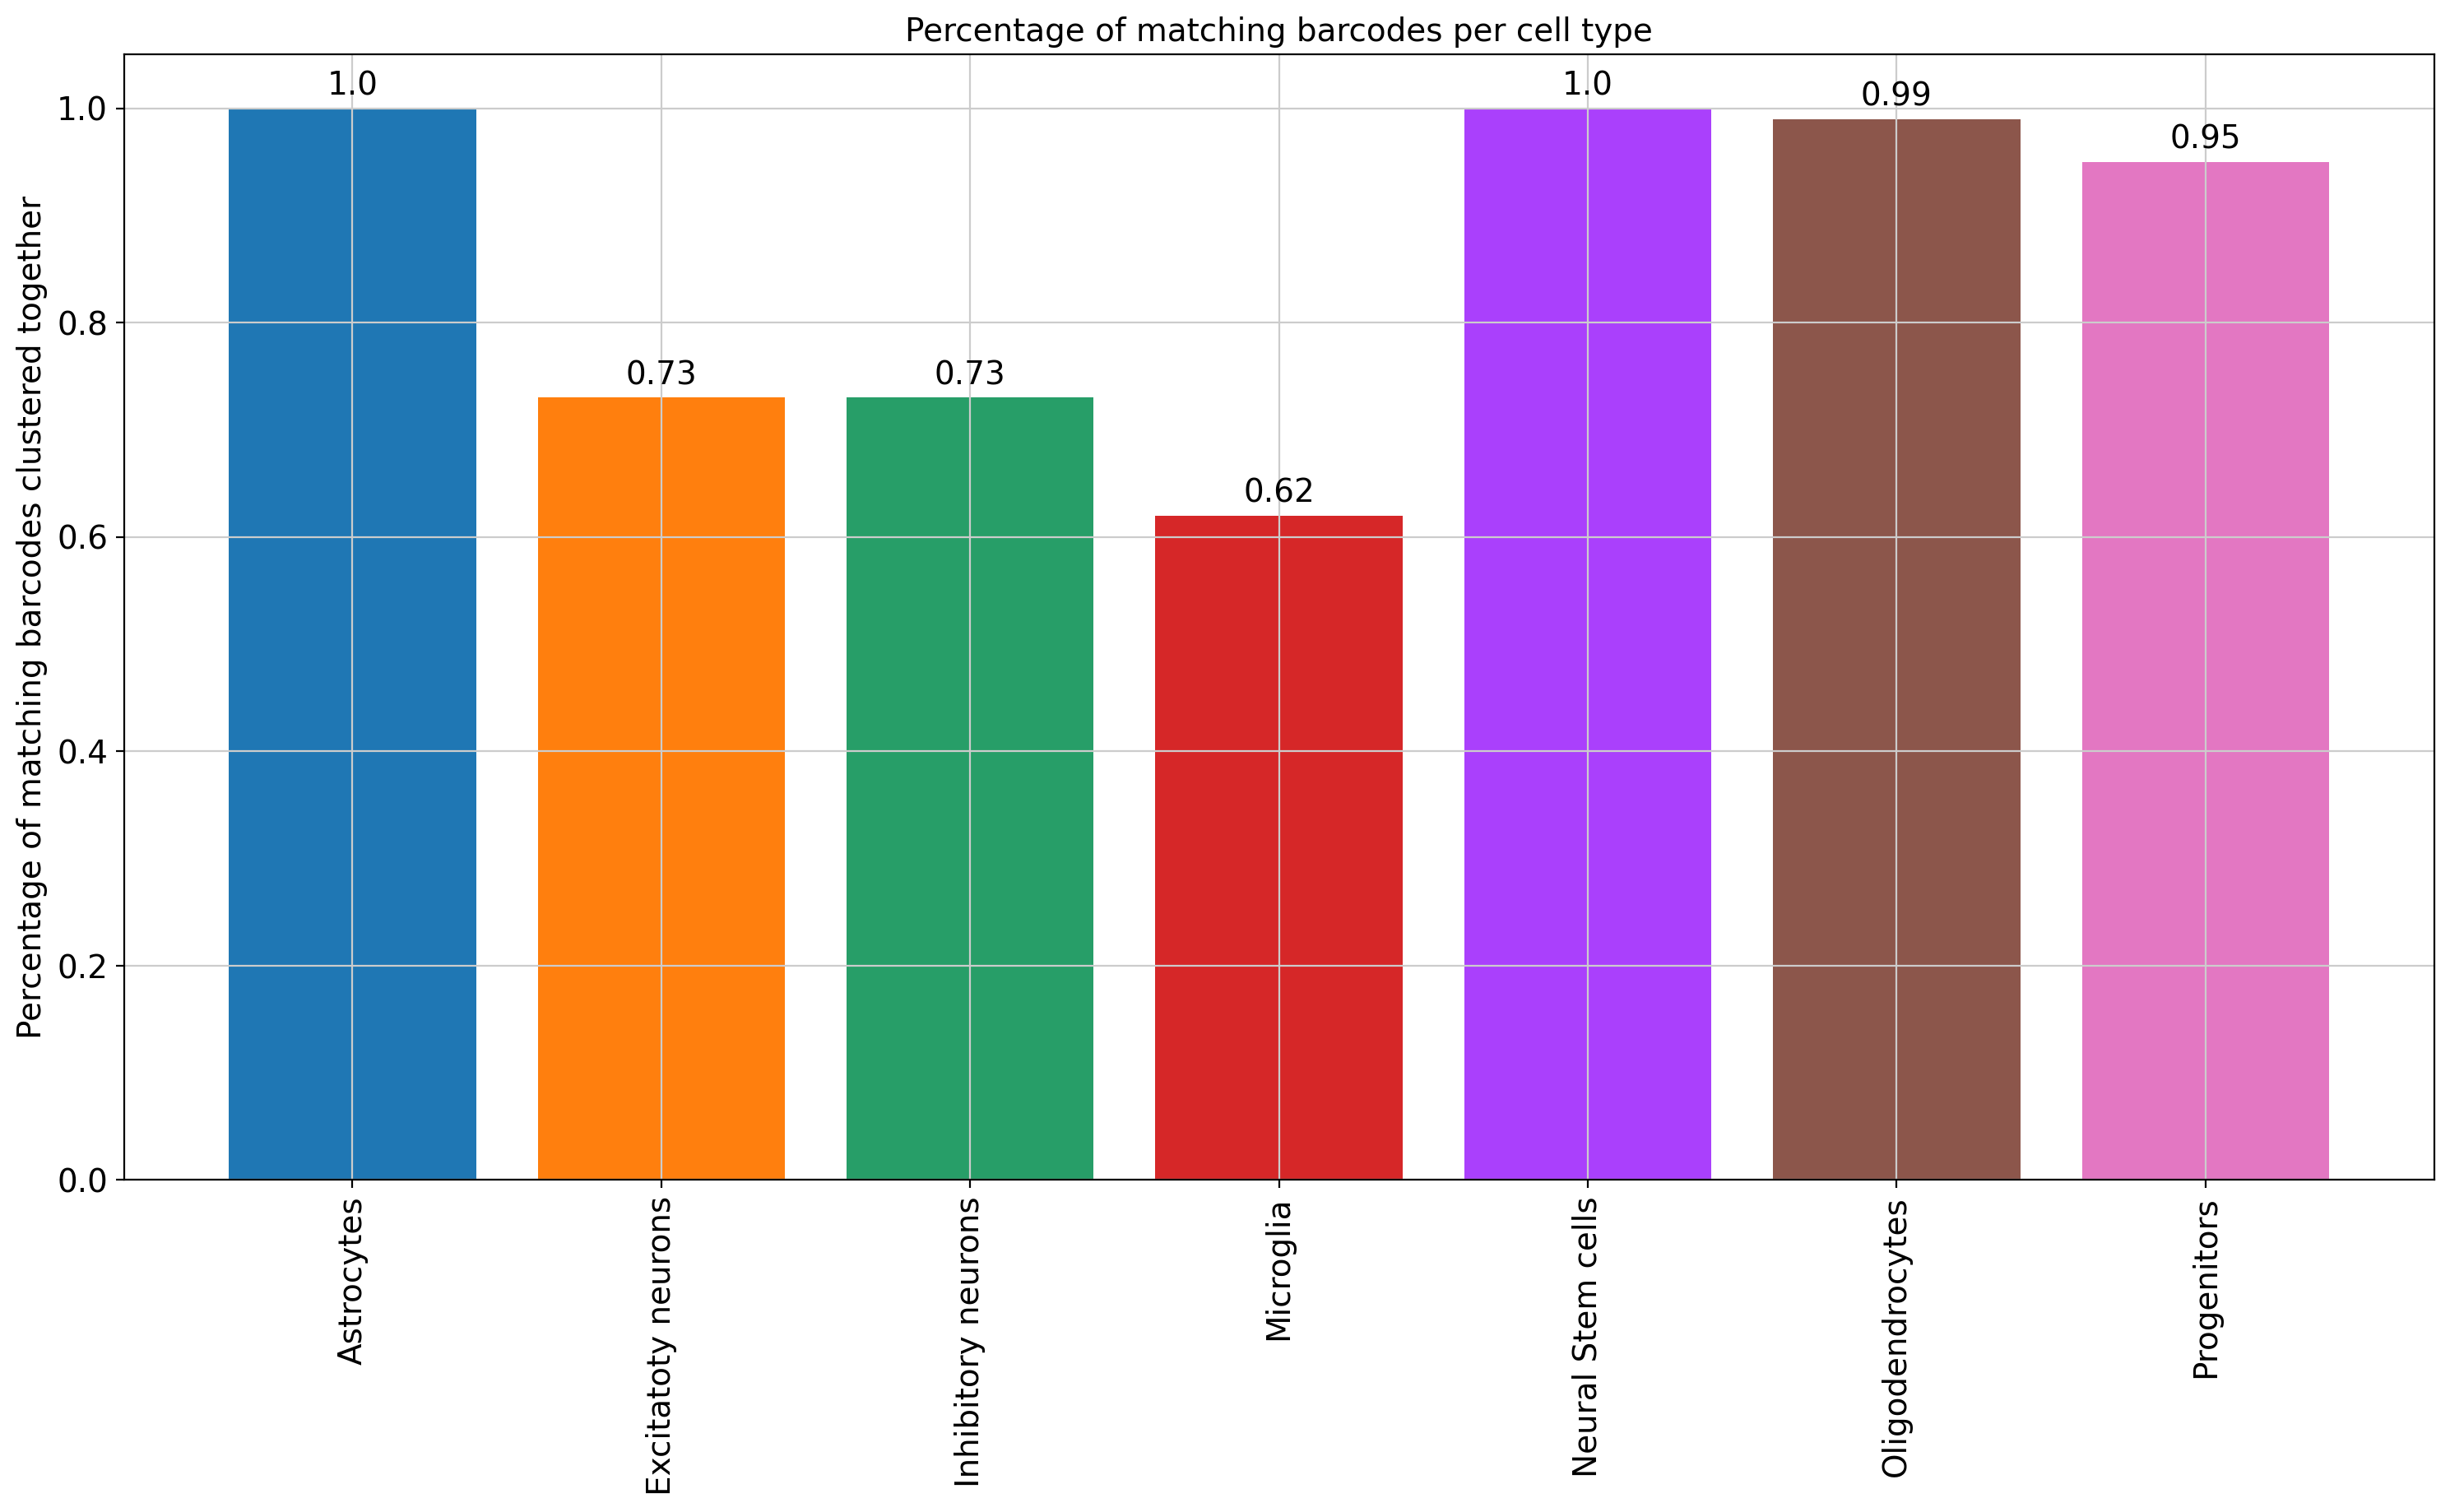

scalex


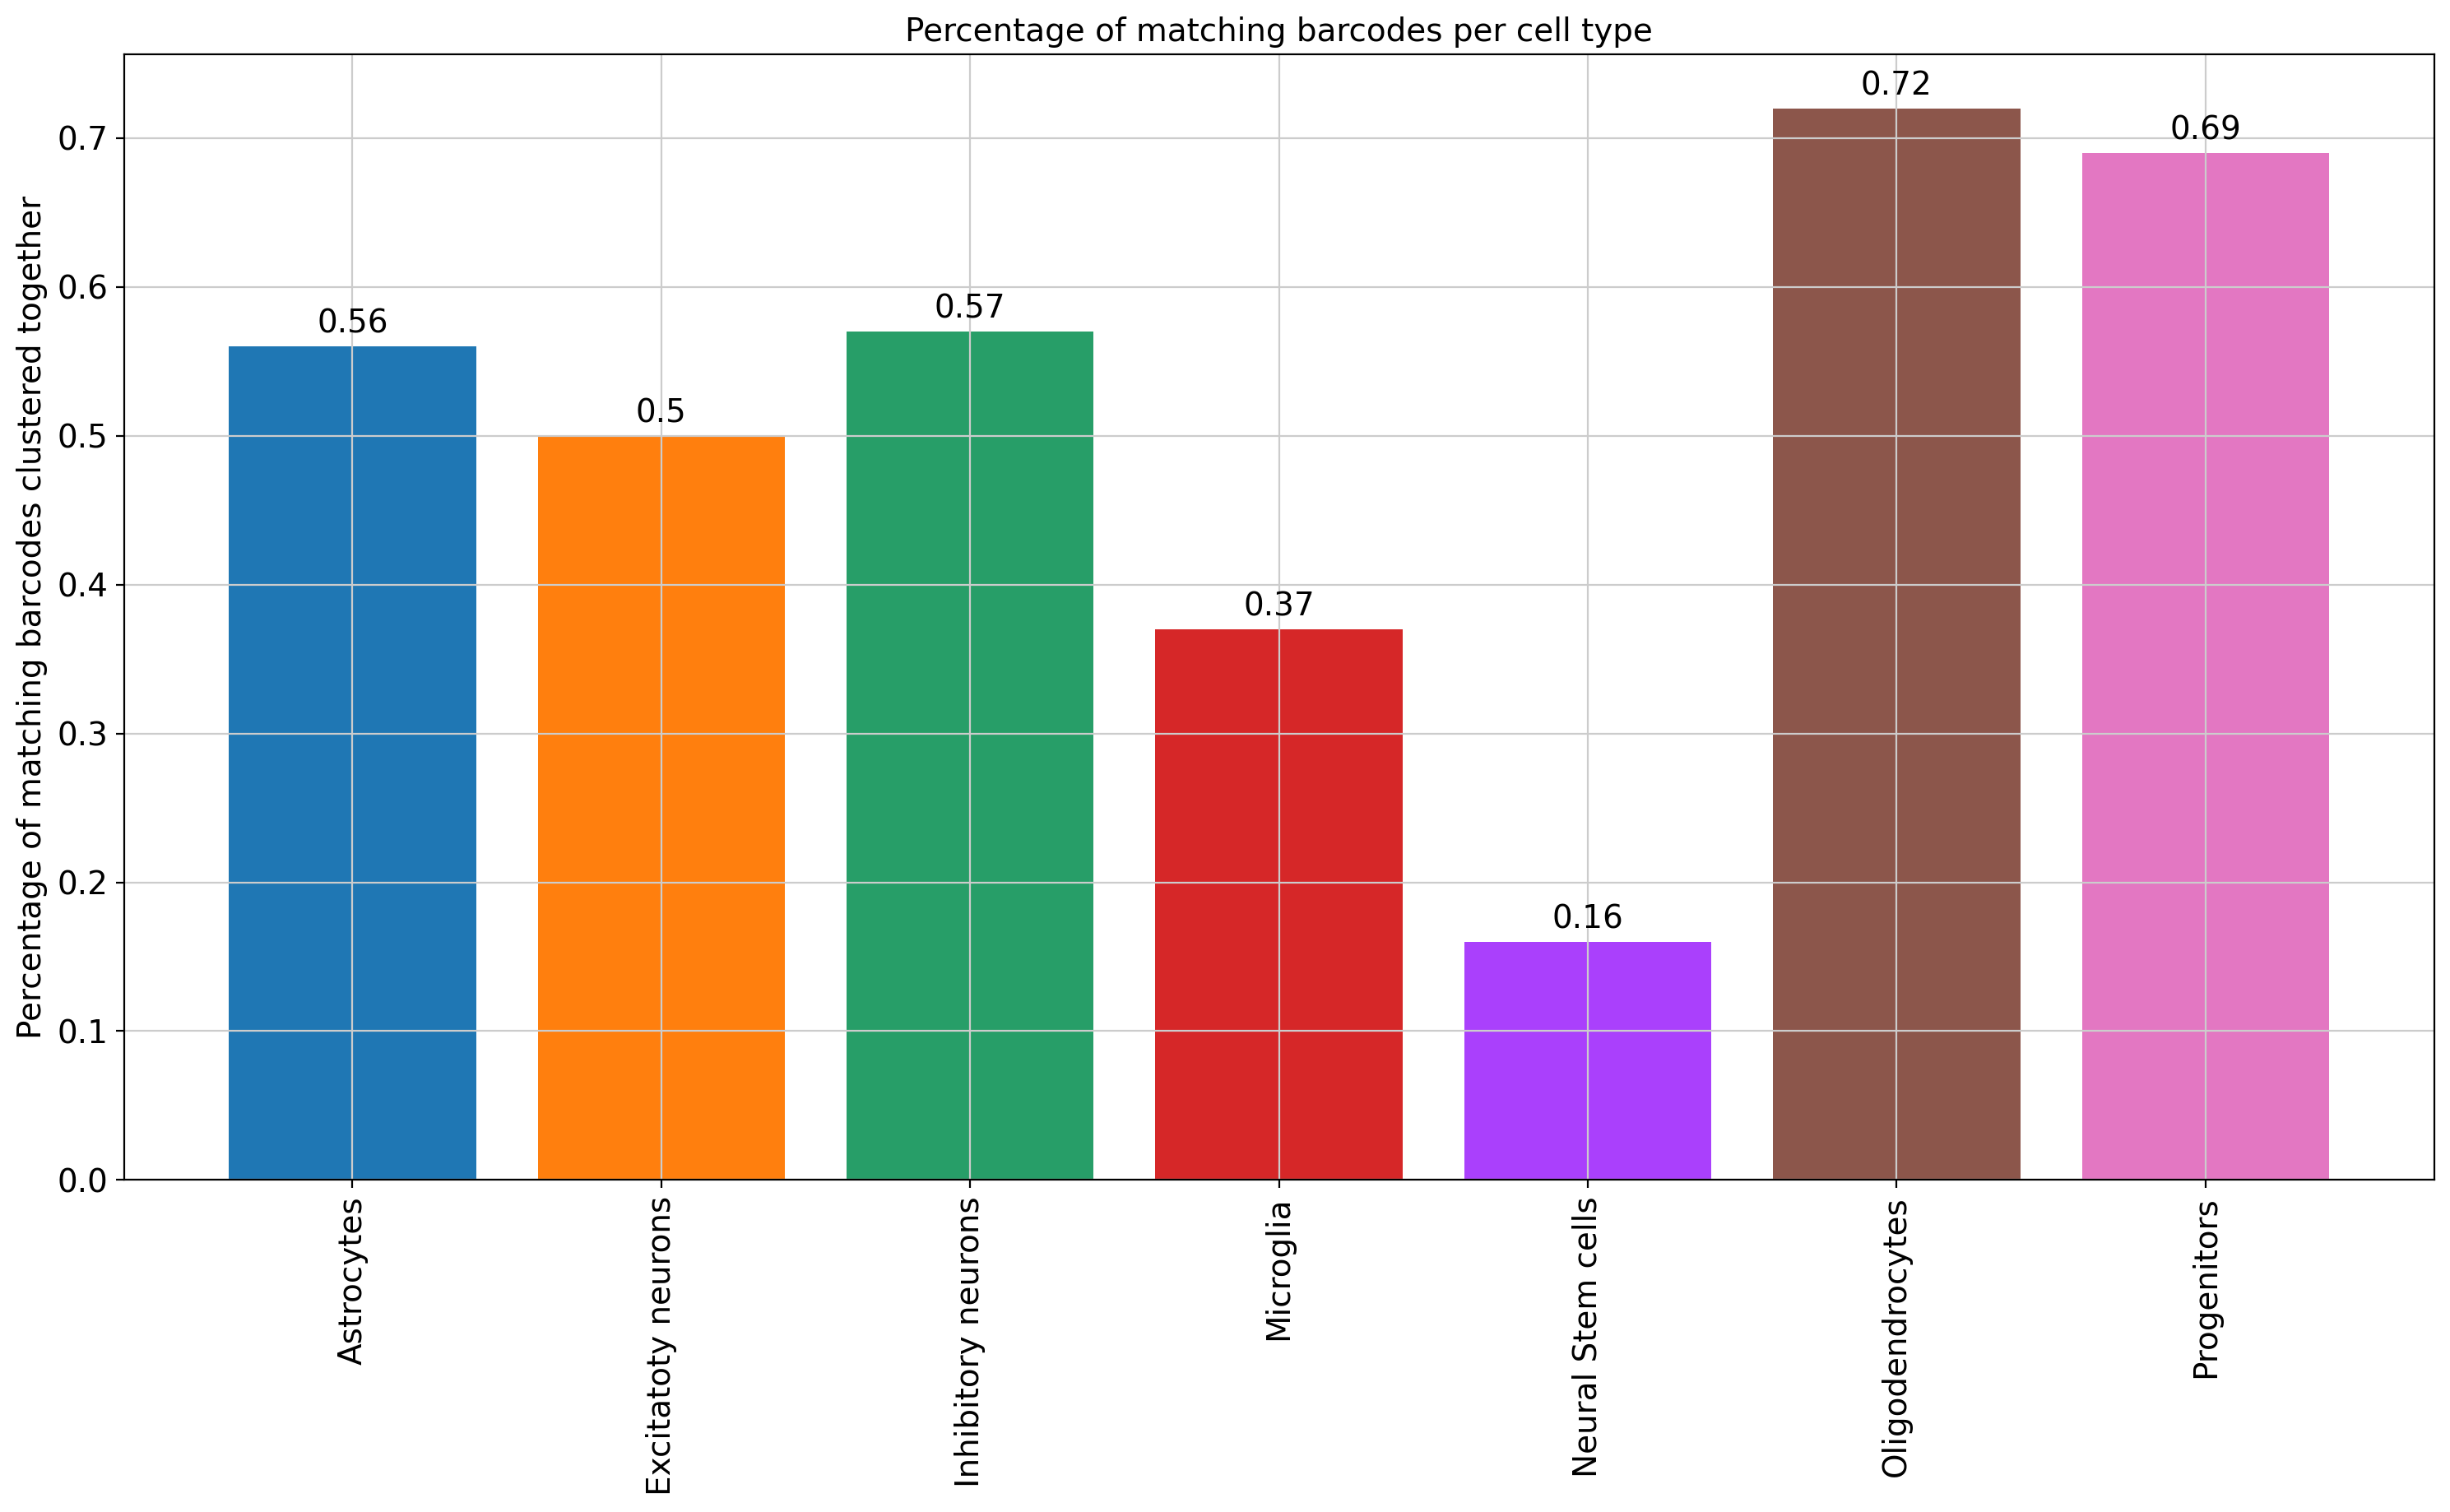

scot


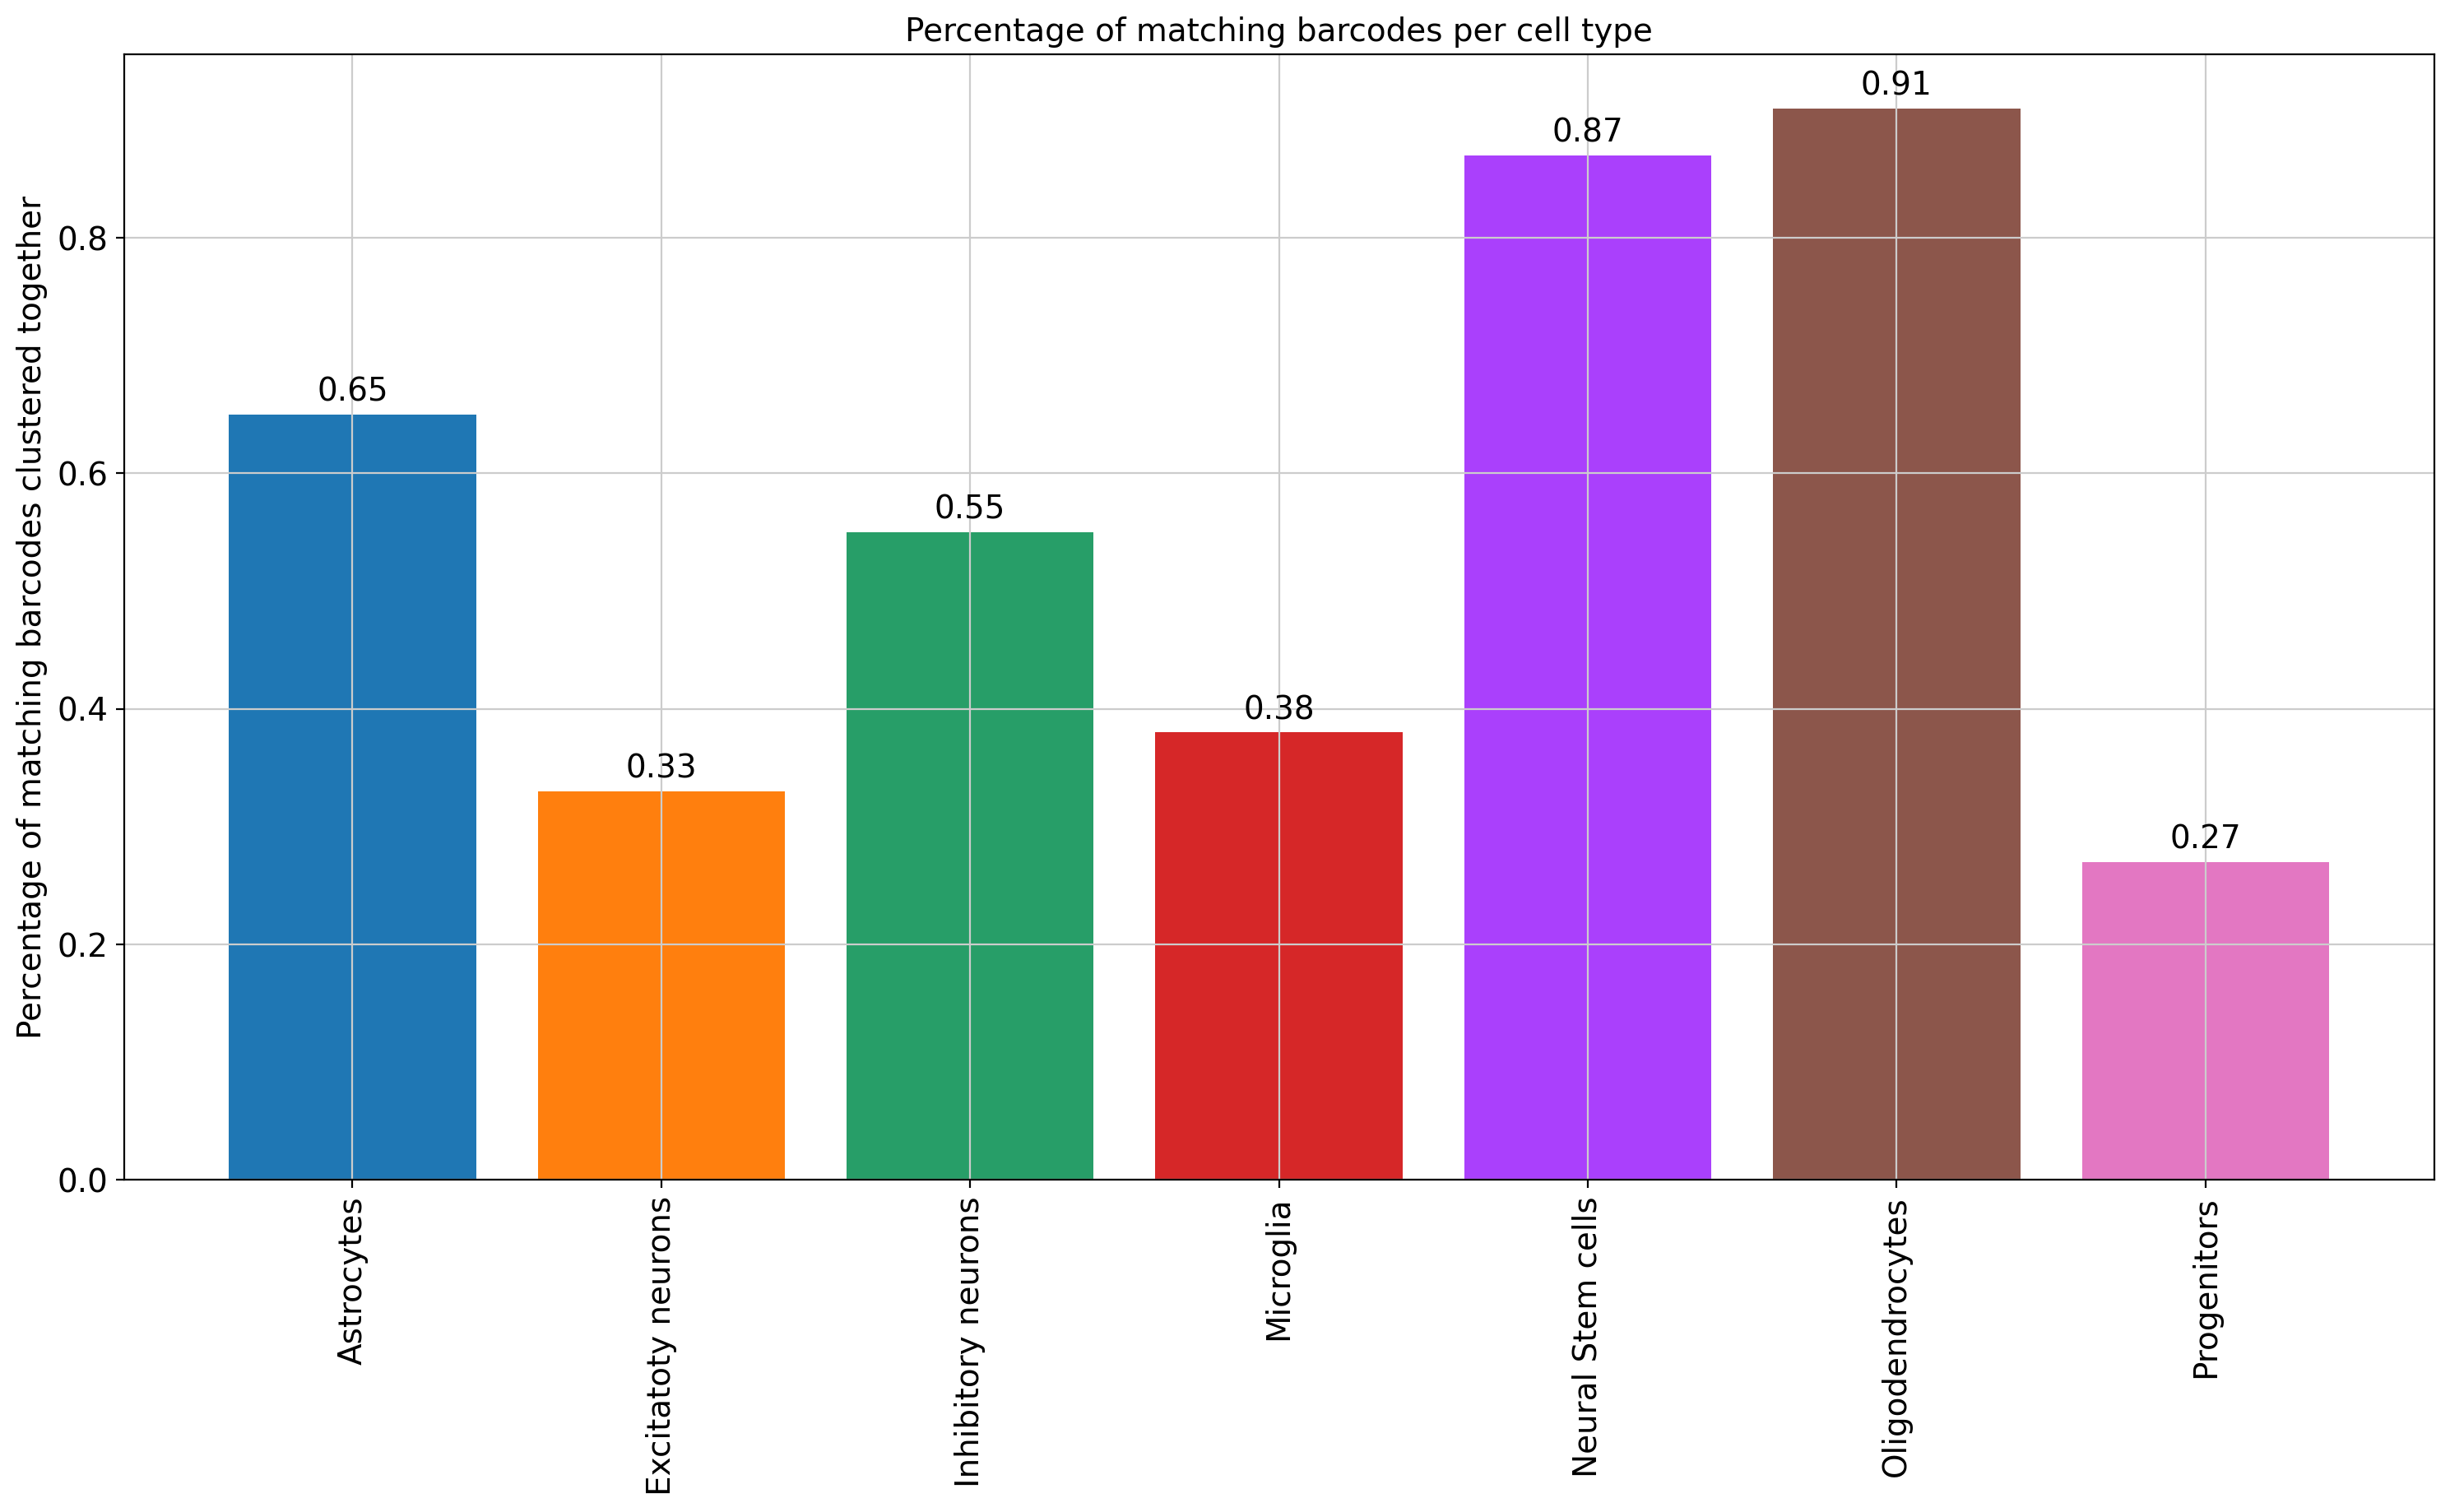

In [11]:
for i, j in zip(adata_list, ids):
    print(j)
    scmoib.pl.accuracy_per_cell_type(i, i.uns['acc_cell_type'], 'broad_annotations')